In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

# from tropical_cyclone_dm import TropicalCycloneSequenceDataModule

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    "MVERegression": "#1f77b4",  # Blue
    "QuantileRegression": "#ff7f0e",  # Orange
    "DKLRegression": "#2ca02c",  # Green
    "LaplaceRegression": "#d62728",  # Red
    "DeepEnsembleRegression": "#9467bd",  # Purple
    "MCDropoutRegression": "#8c564b",  # Brown
    "SWAGRegression": "#e377c2",  # Pink
    "BNN_VI_ELBO_Regression": "#7f7f7f",  # Gray
    "BNN_VI_Regression": "#bcbd25",  # Lime
    "DER": "#bcbd22",  # Lime
    "DUERegression": "#17becf",  # Teal
    "DeterministicRegression": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDRegression": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "calibration": "Calibration",
    "correlation": "Correlation",
    "nll": "NLL",
    "mace": "MACE",
    "crps": "CRPS",
    "proportion_in_0.9_interval": "Proportion in 0.9 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "MVERegression": "MVE",
    "QuantileRegression": "QR",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "CQR",
    "CARDRegression": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/reg_digital_34"
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
    if os.path.exists(os.path.join(os.path.dirname(file), "config.yaml"))
]


# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "method"


STORM_DISPLAY_ORDER = ["all", "TD", "TS", "H1", "H2", "H3", "H5"]

DS_SPLIT = "test"


UQ_METHOD_DISPLAY_ORDER = [
    "DeterministicRegression",
    "MVERegression",
    "DER",
    "QuantileRegression",
    "ConformalQR",
    "DeepEnsembleRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "LaplaceRegression",
    "BNN_VI_ELBO_Regression",
    "DKLRegression",
    "DUERegression",
    "CARDRegression",
]

# Define the groups
UQ_METHOD_GROUPS = {
    "Deterministic": ["MVERegression", "DER"],
    "Quantile": ["QuantileRegression", "ConformalQR"],
    "Bayesian": [
        "MCDropoutRegression",
        "SWAGRegression",
        "LaplaceRegression",
        "BNN_VI_ELBO_Regression",
        "DKLRegression",
        "DUERegression",
    ],
    "Ensemble": ["DeepEnsembleRegression"],
    "Diffusion": ["CARDRegression"],
}

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_BNN_VI_ELBO_Regression_03-01-2024_17-36-47-588963/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_BNN_VI_ELBO_Regression_03-01-2024_17-36-47-588963/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_BNN_VI_ELBO_Regression_03-01-2024_17-36-47-588963/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DKLRegression_03-01-2024_17-41-14-427583/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DKLRegression_03-01-2024_17-41-14-427583/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DKLRegression_03-01-2024_17-41-14-427583/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_MVERegression_03-01-2024_17-36-47-588560/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_MVERegre

## Util functions

## get normaliation params

In [4]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
os.environ["HYDRA_FULL_ERROR"] = "1"
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)

100%|██████████| 14/14 [02:02<00:00,  8.76s/it]


In [5]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_MVERegression_03-01-2024_17-36-47-588560': {'target_mean': 59.43564648600797,
  'target_std': 19.71926368610111},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DKLRegression_03-01-2024_17-41-14-427583': {'target_mean': 59.43564648600797,
  'target_std': 19.71926368610111},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_ConformalQR_03-06-2024_14-57-14-113148': {'target_mean': 59.43564648600797,
  'target_std': 19.71926368610111},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DER_03-05-2024_10-05-24-026860': {'target_mean': 59.43564648600797,
  'target_std': 19.71926368610111},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DeterministicRegression_03-02-2024_09-58-17-465511': {'target_mean': 59.43564648600797,
  'target_std': 19.71926368610111},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DeepEnsemble

## selective prediction thresholds based on validation set

In [6]:
def compute_quantile_and_save(paths: list[str], quantile: float = 0.9):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)

        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            df["target"] = df["target"] * TARGET_STD + TARGET_MEAN
            # threshold = np.quantile(df['pred_uct'], quantile)
            df["storm_category"] = pd.cut(
                df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
            )
            if SELECTIVE_PROCEDURE == "absolute":
                # create a dict over all storm categories and fill values with absolute threshold
                thresholds = {category: SELECTIVE_THRESH for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                method_threshold = df["pred_uct"].quantile(quantile)
                thresholds = {category: method_threshold for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "category_conditional":
                thresholds = (
                    df.groupby("storm_category", observed=False)["pred_uct"]
                    .quantile(quantile)
                    .to_dict()
                )
        else:
            continue

        selective_pred_dict[os.path.dirname(path)] = thresholds
    return selective_pred_dict


dir_paths = [path for path in paths]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths, 0.8)
SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_BNN_VI_ELBO_Regression_03-01-2024_17-36-47-588963': {'TD': 2.0150961198430593,
  'TS': 2.0150961198430593,
  'H1': 2.0150961198430593,
  'H2': 2.0150961198430593,
  'H3': 2.0150961198430593,
  'H4': 2.0150961198430593,
  'H5': 2.0150961198430593},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DKLRegression_03-01-2024_17-41-14-427583': {'TD': 9.164808837061546,
  'TS': 9.164808837061546,
  'H1': 9.164808837061546,
  'H2': 9.164808837061546,
  'H3': 9.164808837061546,
  'H4': 9.164808837061546,
  'H5': 9.164808837061546},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_MVERegression_03-01-2024_17-36-47-588560': {'TD': 10.138239403892372,
  'TS': 10.138239403892372,
  'H1': 10.138239403892372,
  'H2': 10.138239403892372,
  'H3': 10.138239403892372,
  'H4': 10.138239403892372,
  'H5': 10.138239403892372},
 '/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_D

In [7]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
3,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
4,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
5,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
6,MVERegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
7,MVERegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
8,MVERegression,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...
9,DER,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...,/p/project/hai_uqmethodbox/experiment_output/r...


In [8]:
empty_result = {
    "accuracy": {
        "mae": np.nan,
        "rmse": np.nan,
        "mdae": np.nan,
        "marpd": np.nan,
        "r2": np.nan,
        "corr": np.nan,
    },
    "avg_calibration": {"rms_cal": np.nan, "ma_cal": np.nan, "miscal_area": np.nan},
    "sharpness": {"sharp": np.nan},
    "scoring_rule": {
        "nll": np.nan,
        "crps": np.nan,
        "check": np.nan,
        "interval": np.nan,
    },
}


def compute_metrics_for_predictions(
    csv_path: str, selective_pred: bool, normalized: bool = False
) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"],
    )

    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    # Apply the storm category
    pred_df["storm_category"] = pd.cut(
        pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
    )
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:
        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)]]
            grouped = pred_df.groupby("storm_category", observed=False)

            # Apply the selective prediction filter to each group
            pred_df = grouped.apply(
                lambda group: group[
                    group["pred_uct"]
                    <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)][group.name]
                ]
            )

            # Reset the index of the DataFrame
            pred_df.reset_index(drop=True, inplace=True)
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)[
                "pred"
            ].count()

        if len(pred_df) > 0:
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = [
            "scoring_rule",
            "avg_calibration",
            "sharpness",
            "accuracy",
        ]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {
            "accuracy": uct.metrics.get_all_accuracy_metrics(
                pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze()
            )
        }

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [
            f"{inner_key}"
            for outer_key, inner_dict in empty_result.items()
            for inner_key in inner_dict.keys()
        ]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    split_name = csv_path.split(os.sep)[-1].split(".")[0]
    if split_name == "preds":
        split_name = "preds_test"
    df["split"] = split_name
    df["pred_path"] = csv_path

    # count
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [9]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_uncertainty_df(overview_df):
    def parallel_process(
        paths: List[str], num_processes: int, selective_pred: bool, normalised: bool
    ):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        results = pool.starmap(
            compute_metrics_for_predictions_wrapper,
            [(path, selective_pred, normalised) for path in paths],
        )
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    paths = overview_df["pred_path"].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8 

    uqmetric_df = parallel_process(
        paths, num_processes, selective_pred=False, normalised=False
    )
    selective_df = parallel_process(
        paths, num_processes, selective_pred=True, normalised=False
    )

    # merge model name column
    uqmetric_df = pd.merge(
        left=uqmetric_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )
    selective_df = pd.merge(
        left=selective_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics


/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics


/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_df = grouped.apply(
/tmp/ipykernel_30320/3130177803.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

 (1/n) Calculating accuracy metrics


(          nll      crps     check   interval   rms_cal    ma_cal  miscal_area  \
 0   14.630856  5.685700  2.857681  46.017702  0.403755  0.353120     0.356687   
 1   15.815232  6.081975  3.056088  49.935901  0.402771  0.352227     0.355785   
 2    9.818010  4.445761  2.236429  33.865048  0.358972  0.315764     0.318953   
 3    3.673099  5.308277  2.680290  26.428143  0.006964  0.005942     0.005992   
 4    3.773264  5.670494  2.862821  29.393169  0.016588  0.013277     0.013408   
 5    3.695657  5.347949  2.700164  27.223878  0.017136  0.014340     0.014483   
 6    3.632817  5.203742  2.627556  25.462339  0.046559  0.040703     0.041115   
 7    3.735829  5.584534  2.819552  27.852599  0.069070  0.061410     0.062031   
 8    3.633283  5.227362  2.639395  25.598194  0.051846  0.044886     0.045340   
 9    4.305333  7.658545  3.866508  47.261165  0.353543  0.310306     0.313440   
 10   4.315327  7.863817  3.970175  47.910566  0.341361  0.301212     0.304255   
 11   4.310764  

# Overview Function

In [10]:
with pd.option_context("display.max_colwidth", None):
    display(
        uq_metric_df[uq_metric_df["uqmethod"] == "DUERegression"][
            ["pred_path", "split", "rmse", "nll", "crps", "sharp"]
        ]
    )

,pred_path,split,rmse,nll,crps,sharp
18,/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DUERegression_03-01-2024_17-41-14-427945/preds_val.csv,preds_val,8.628492,3.576567,4.826356,8.444391
19,/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DUERegression_03-01-2024_17-41-14-427945/preds_test.csv,preds_test,9.458079,3.680091,5.223395,8.421306
20,/p/project/hai_uqmethodbox/experiment_output/reg_digital_34/cyclone_DUERegression_03-01-2024_17-41-14-427945/preds_train.csv,preds_train,6.188129,3.319713,3.567178,8.424688


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [11]:
diff_df = pd.DataFrame()

for column in uq_metric_df.columns:
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        diff_df[column] = uq_metric_df[column]

display(
    diff_df[diff_df["split"] == "preds_train"][
        ["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]
    ]
)

,uqmethod,split,nll,sharp,mae,rmse,pred_path
2,BNN_VI_ELBO_Regression,preds_train,-0.894317,0.166659,0.002092,0.002225,/p/project/hai_uqmethodbox/experiment_output/r...
5,DKLRegression,preds_train,-0.045337,0.020250,-0.342601,-0.388150,/p/project/hai_uqmethodbox/experiment_output/r...
8,MVERegression,preds_train,0.053060,1.005326,0.406872,0.561447,/p/project/hai_uqmethodbox/experiment_output/r...
11,DER,preds_train,0.045175,1.338414,0.626788,0.852200,/p/project/hai_uqmethodbox/experiment_output/r...
14,SWAGRegression,preds_train,0.067811,0.683555,0.643007,0.938167,/p/project/hai_uqmethodbox/experiment_output/r...
17,CARDRegression,preds_train,0.019598,0.386460,0.045220,0.065889,/p/project/hai_uqmethodbox/experiment_output/r...
20,DUERegression,preds_train,-0.009728,0.029154,-0.131928,-0.125115,/p/project/hai_uqmethodbox/experiment_output/r...
23,BNN_VI_Regression,preds_train,0.063404,0.606547,0.630653,0.833605,/p/project/hai_uqmethodbox/experiment_output/r...
26,ConformalQR,preds_train,0.064414,0.707778,0.641807,0.940022,/p/project/hai_uqmethodbox/experiment_output/r...
29,QuantileRegression,preds_train,0.088287,0.744187,0.641807,0.940022,/p/project/hai_uqmethodbox/experiment_output/r...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'BNN_VI_ELBO_Regression'),
  Text(1, 0, 'DKLRegression'),
  Text(2, 0, 'MVERegression'),
  Text(3, 0, 'DER'),
  Text(4, 0, 'SWAGRegression'),
  Text(5, 0, 'CARDRegression'),
  Text(6, 0, 'DUERegression'),
  Text(7, 0, 'BNN_VI_Regression'),
  Text(8, 0, 'ConformalQR'),
  Text(9, 0, 'QuantileRegression'),
  Text(10, 0, 'MCDropoutRegression'),
  Text(11, 0, 'DeepEnsembleRegression'),
  Text(12, 0, 'LaplaceRegression'),
  Text(13, 0, 'DeterministicRegression')])

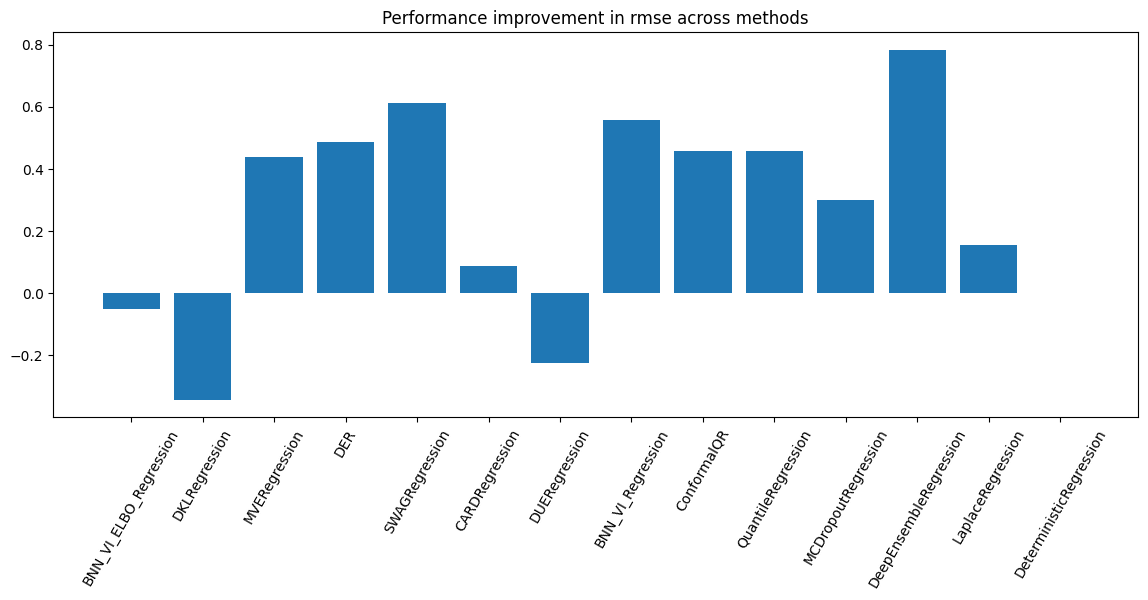

In [12]:
metric = "rmse"
diff_train = diff_df[diff_df["split"] == "preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"] == "preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [13]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,14.630856,5.685700,2.857681,46.017702,0.403755,0.353120,0.356687,1.789868,6.508837,8.342076,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,8111,3519,1264,1095,42,0,14031,BNN_VI_ELBO_Regression
1,15.815232,6.081975,3.056088,49.935901,0.402771,0.352227,0.355785,1.807835,6.917852,9.154726,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,12487,4824,1495,1150,55,0,20011,BNN_VI_ELBO_Regression
2,9.818010,4.445761,2.236429,33.865048,0.358972,0.315764,0.318953,1.812029,5.237346,6.852531,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,39026,15320,5345,4461,348,0,64500,BNN_VI_ELBO_Regression
3,3.673099,5.308277,2.680290,26.428143,0.006964,0.005942,0.005992,9.170867,7.460216,9.504660,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,8111,3519,1264,1095,42,0,14031,DKLRegression
4,3.773264,5.670494,2.862821,29.393169,0.016588,0.013277,0.013408,9.164956,7.787491,10.351819,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,12487,4824,1495,1150,55,0,20011,DKLRegression
5,3.695657,5.347949,2.700164,27.223878,0.017136,0.014340,0.014483,9.167711,7.409750,9.702614,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,39026,15320,5345,4461,348,0,64500,DKLRegression
6,3.632817,5.203742,2.627556,25.462339,0.046559,0.040703,0.041115,8.840698,7.398432,9.325043,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,8111,3519,1264,1095,42,0,14031,MVERegression
7,3.735829,5.584534,2.819552,27.852599,0.069070,0.061410,0.062031,8.781119,7.896993,10.103896,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,12487,4824,1495,1150,55,0,20011,MVERegression
8,3.633283,5.227362,2.639395,25.598194,0.051846,0.044886,0.045340,8.822449,7.455287,9.439644,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,39026,15320,5345,4461,348,0,64500,MVERegression
9,4.305333,7.658545,3.866508,47.261165,0.353543,0.310306,0.313440,28.651216,6.909476,8.702349,...,/p/project/hai_uqmethodbox/experiment_output/r...,0,8111,3519,1264,1095,42,0,14031,DER


The number of samples being removed per category as a percentage.

In [14]:
sample_remain_pct = (
    uq_metric_df[CLASS_LABELS + ["count_total"]]
    - selective_df[CLASS_LABELS + ["count_total"]]
) / uq_metric_df[CLASS_LABELS + ["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])
print(sample_remain_pct)

                  UQ Method        split  TD        TS        H1        H2  \
0    BNN_VI_ELBO_Regression    preds_val NaN  0.055973  0.150327  0.497627   
1    BNN_VI_ELBO_Regression   preds_test NaN  0.071995  0.207919  0.496990   
2    BNN_VI_ELBO_Regression  preds_train NaN  0.083278  0.172063  0.548363   
3             DKLRegression    preds_val NaN  0.126495  0.132708  0.549051   
4             DKLRegression   preds_test NaN  0.111156  0.107587  0.462876   
5             DKLRegression  preds_train NaN  0.118254  0.103003  0.499158   
6             MVERegression    preds_val NaN  0.136111  0.364592  0.240506   
7             MVERegression   preds_test NaN  0.134700  0.336235  0.305686   
8             MVERegression  preds_train NaN  0.130144  0.333812  0.283630   
9                       DER    preds_val NaN  0.180496  0.271668  0.092563   
10                      DER   preds_test NaN  0.183150  0.271559  0.209365   
11                      DER  preds_train NaN  0.187490  0.268146

                   UQ Method storm_category     value
0     BNN_VI_ELBO_Regression             TD       NaN
1              DKLRegression             TD       NaN
2              MVERegression             TD       NaN
3                        DER             TD       NaN
4             SWAGRegression             TD       NaN
..                       ...            ...       ...
107       QuantileRegression    count_total  0.214832
108      MCDropoutRegression    count_total  0.201889
109   DeepEnsembleRegression    count_total  0.215182
110        LaplaceRegression    count_total  0.179651
111  DeterministicRegression    count_total  0.000000

[112 rows x 3 columns]
                  UQ Method storm_category  value
0    BNN_VI_ELBO_Regression             TD    NaN
1             DKLRegression             TD    NaN
2             MVERegression             TD    NaN
3                       DER             TD    NaN
4            SWAGRegression             TD    NaN
..                      ... 

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

KeyError: 'BNN_VI_Regression'

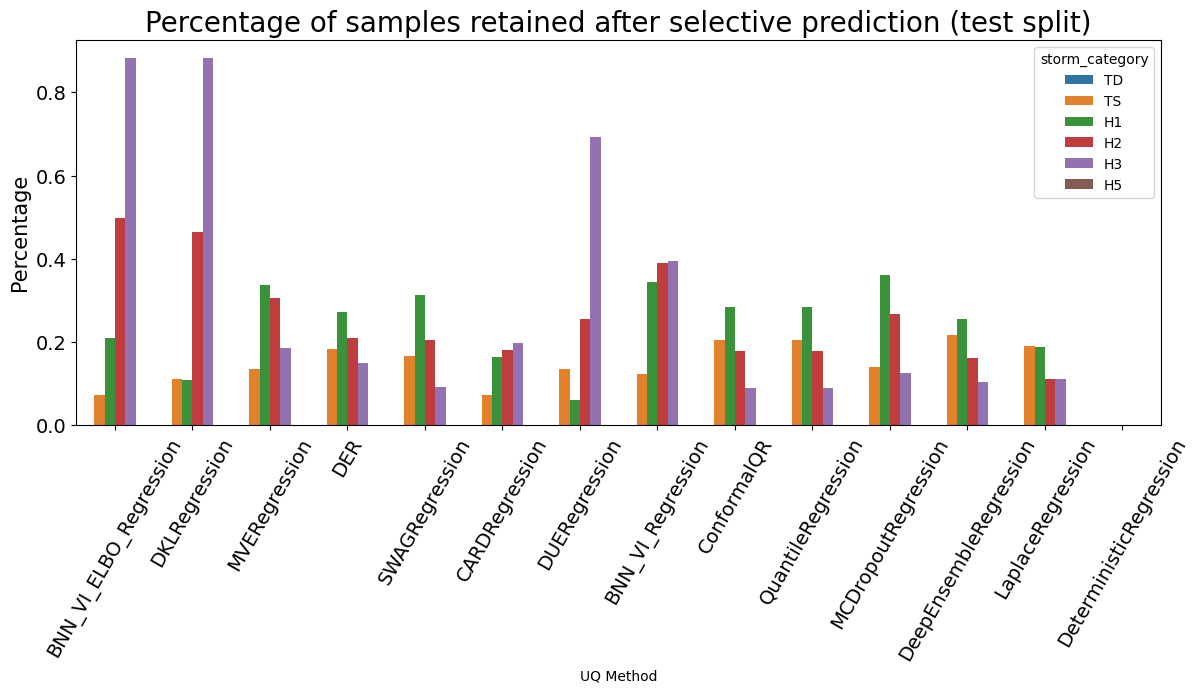

In [15]:
def plot_sample_percentage(sample_remain_pct, split_type):
    # Filter the DataFrame based on the split type
    count = sample_remain_pct[
        sample_remain_pct["split"] == f"preds_{split_type}"
    ].reset_index(drop=True)

    # Melt the DataFrame to long format
    count = pd.melt(
        count,
        id_vars="UQ Method",
        value_vars=CLASS_LABELS + ["count_total"],
        var_name="storm_category",
    )
    print(count)
    count = count[count["storm_category"].isin(STORM_DISPLAY_ORDER)]

    print(count)
    # Create the bar plot
    fig, ax = plt.subplots(1)
    sns.barplot(x="UQ Method", y="value", hue="storm_category", data=count, ax=ax)
    plt.ylabel("Percentage", fontsize=15)
    plt.title(
        f"Percentage of samples retained after selective prediction ({split_type} split)",
        fontsize=20,
    )
    plt.xticks(rotation=60, fontsize=14)
    plt.yticks(fontsize=14)

    # Set the x-tick labels using the VAR_TO_PLOT_LABEL dictionary
    ax.set_xticklabels(
        [VAR_TO_PLOT_LABEL[label.get_text()] for label in ax.get_xticklabels()]
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop={"size": 15})

    plt.show()

plot_sample_percentage(sample_remain_pct, DS_SPLIT)

# All preds in a single DF

In [16]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    if row["split"] == "preds.csv":
        pred_df["split"] = "preds_test"
    else:
        pred_df["split"] = row["split"].split(".")[0]

    pred_df["pred_path"] = row["pred_path"]
    all_test_pred_df.append(pred_df)

from scipy import stats

# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)


def get_normalization_params(group):
    pred_path = group["pred_path"].iloc[0]
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"],
    )
    group["target_mean"] = TARGET_MEAN
    group["target_std"] = TARGET_STD
    return group


all_test_pred_df = all_test_pred_df.groupby("pred_path").apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (
    all_test_pred_df["pred"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (
    all_test_pred_df["target"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = (
    all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]
)

all_test_pred_df["storm_category"] = pd.cut(
    all_test_pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"]) ** 2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(
    all_test_pred_df["pred"] - all_test_pred_df["target"],
    scale=all_test_pred_df["pred_uct"],
)

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df["date"] = pd.to_datetime(
    all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
)

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how="any")
all_test_pred_df

/tmp/ipykernel_30320/1574974368.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_test_pred_df = all_test_pred_df.groupby("pred_path").apply(get_normalization_params)


,pred,pred_uct,epistemic_uct,target,storm_id,index,wind_speed,uqmethod,split,pred_path,aleatoric_uct,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date
0,35.013427,2.070379,0.104993,35.0,198710,930,35,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/r...,NaN,NaN,NaN,59.435646,19.719264,TS,0.000180,0.013427,1.646691,NaT
1,35.669663,2.020511,0.102464,35.0,198710,931,35,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/r...,NaN,NaN,NaN,59.435646,19.719264,TS,0.448448,0.669662,1.677213,NaT
2,36.613647,2.064065,0.104673,35.0,198710,932,35,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/r...,NaN,NaN,NaN,59.435646,19.719264,TS,2.603857,1.613647,1.949207,NaT
3,38.440170,2.017181,0.102295,35.0,198710,933,35,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/r...,NaN,NaN,NaN,59.435646,19.719264,TS,11.834766,3.440170,3.074893,NaT
4,37.567370,1.892941,0.095995,35.0,198710,934,35,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/r...,NaN,NaN,NaN,59.435646,19.719264,TS,6.591385,2.567369,2.476826,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379583,39.764183,10.070904,0.017394,35.0,202223,101276,35,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/r...,0.510418,NaN,NaN,59.435646,19.719264,TS,22.697441,4.764183,3.340484,NaT
1379584,39.731336,9.988435,0.017027,35.0,202223,101277,35,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/r...,0.506246,NaN,NaN,59.435646,19.719264,TS,22.385537,4.731336,3.332553,NaT
1379585,38.201291,9.042088,0.018558,35.0,202223,101278,35,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/r...,0.458165,NaN,NaN,59.435646,19.719264,TS,10.248260,3.201290,3.183502,NaT
1379586,37.845299,8.698650,0.019137,35.0,202223,101279,35,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/r...,0.440709,NaN,NaN,59.435646,19.719264,TS,8.095723,2.845298,3.135602,NaT


In [17]:
# Filter for specific method
cqr = all_test_pred_df[all_test_pred_df["uqmethod"] == "ConformalQR"]
qr = all_test_pred_df[all_test_pred_df["uqmethod"] == "QuantileRegression"]

# Filter for specific split
cqr_split = cqr[cqr["split"] == f"preds_{DS_SPLIT}"]
qr_split = qr[qr["split"] == f"preds_{DS_SPLIT}"]

# Sort rows
cqr_sorted = cqr_split.sort_values(by="index")
qr_sorted = qr_split.sort_values(by="index")

In [18]:
cqr_sorted[["index", "pred_uct"]]

,index,pred_uct
295626,930,8.936360
295627,931,8.887807
295628,932,8.817637
295629,933,9.119487
295630,934,9.366444
...,...,...
315632,101248,10.656668
315633,101249,10.158648
315634,101250,10.027677
315635,101251,9.900906


In [19]:
qr_sorted[["index", "pred_uct"]]

,index,pred_uct
1182504,930,4.218722
1182505,931,4.170167
1182506,932,4.099997
1182507,933,4.401848
1182508,934,4.648805
...,...,...
1202510,101248,5.939029
1202511,101249,5.441009
1202512,101250,5.310038
1202513,101251,5.183267


In [20]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [21]:
laplace_df = all_test_pred_df[all_test_pred_df["uqmethod"] == "LaplaceRegression"]
abs(laplace_df["target_mean"] - laplace_df["target"]).std() / 26.795276641845703

0.3962314528281227

## selective prediction

In [ ]:
OG_SELECTIVE_PROCEDURE = "method"


def compute_quantile_and_save(
    paths: list[str],
    quantiles: list[float] = [
        0.95,
        0.9,
        0.85,
        0.8,
        0.75,
        0.7,
        0.65,
        0.6,
        0.55,
        0.5,
        0.45,
        0.4,
        0.35,
        0.3,
        0.25,
        0.2,
        0.15,
        0.1,
        0.05,
    ],
):
    selective_pred_dict = {}
    for path in paths:
        # assert "val" in path
        df = pd.read_csv(path)
        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            if OG_SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                quant_dict = {
                    quantile: df["pred_uct"].quantile(quantile)
                    for quantile in quantiles
                }
        selective_pred_dict[os.path.dirname(path)] = quant_dict
    return selective_pred_dict


dir_paths = [path for path in paths if "val" in path]
OG_SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths)
OG_SELECTIVE_PRED_DICT

from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Initialize an empty DataFrame to store the RMSE
rmse_df = pd.DataFrame(columns=["pred_path", "threshold", "RMSE"])

# Iterate over each unique "pred_path" in all_test_pred_df
for pred_path in tqdm(all_test_pred_df["pred_path"].unique()):
    exp_path = os.path.dirname(pred_path)
    
    if "DeterministicRegression" in exp_path:
        continue
    if exp_path in OG_SELECTIVE_PRED_DICT:
        path_df = all_test_pred_df[(all_test_pred_df["pred_path"] == pred_path)]
        # compute rmse on full df
        full_rmse = mean_squared_error(
            path_df["pred"], path_df["target"], squared=False
        )
        row_df = pd.DataFrame(
            {"pred_path": [pred_path], "threshold": [1.0], "RMSE": [full_rmse]}
        )
        rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)
        # Iterate over each threshold
        for threshold, value in tqdm(OG_SELECTIVE_PRED_DICT[exp_path].items()):

            filtered_df = path_df[(path_df["pred_uct"] <= value)]
        
            if len(filtered_df) != 0:
                # Compute the RMSE for the filtered DataFrame
                rmse = mean_squared_error(
                    filtered_df["pred"], filtered_df["target"], squared=False
                )

                # Create a new DataFrame for the current row
                row_df = pd.DataFrame(
                    {"pred_path": [pred_path], "threshold": [threshold], "RMSE": [rmse]}
                )
            else:
                row_df = pd.DataFrame(
                    {
                        "pred_path": [pred_path],
                        "threshold": [threshold],
                        "RMSE": [np.nan],
                    }
                )

            # Concatenate the new row with rmse_df
            rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)

meta_df = all_test_pred_df.drop_duplicates(subset=["pred_path"])
rmse_df = rmse_df.merge(
    meta_df[["pred_path", "split", "uqmethod"]], on="pred_path", how="left"
)

  0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipykernel_18531/3128736995.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, row_df], ignore_index=True)


100%|██████████| 42/42 [00:05<00:00,  7.43it/s]


In [ ]:
OG_SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_BNN_VI_Regression_02-26-2024_10-40-18-557918': {0.95: 17.307902074939282,
  0.9: 14.747403990141079,
  0.85: 13.20869751660792,
  0.8: 11.8258523383745,
  0.75: 10.77943338870107,
  0.7: 10.007524284408554,
  0.65: 9.503955948802528,
  0.6: 9.063320877149394,
  0.55: 8.731076587518722,
  0.5: 8.49130748904841,
  0.45: 8.305902524848173,
  0.4: 8.14010245926607,
  0.35: 8.007834338647045,
  0.3: 7.881350380563923,
  0.25: 7.778120770879967,
  0.2: 7.682397054275278,
  0.15: 7.585991464851317,
  0.1: 7.494377138962641,
  0.05: 7.412773729640479},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876': {0.95: 15.057757007129197,
  0.9: 13.782237163704316,
  0.85: 13.312188581210199,
  0.8: 13.093528333285075,
  0.75: 12.965642915210598,
  0.7: 12.89624328096157,
  0.65: 12.855224534554305,
  0.6: 12.828756159630343,
  0.55: 12.811829448979054,
  0.5: 1

In [ ]:
rmse_df

,pred_path,threshold,RMSE,split,uqmethod
0,/p/project/hai_uqmethodbox/experiment_output/m...,1.00,9.274502,preds_test,BNN_VI_ELBO_Regression
1,/p/project/hai_uqmethodbox/experiment_output/m...,0.95,9.103309,preds_test,BNN_VI_ELBO_Regression
2,/p/project/hai_uqmethodbox/experiment_output/m...,0.90,8.950439,preds_test,BNN_VI_ELBO_Regression
3,/p/project/hai_uqmethodbox/experiment_output/m...,0.85,8.821426,preds_test,BNN_VI_ELBO_Regression
4,/p/project/hai_uqmethodbox/experiment_output/m...,0.80,8.656174,preds_test,BNN_VI_ELBO_Regression
...,...,...,...,...,...
775,/p/project/hai_uqmethodbox/experiment_output/m...,0.25,5.439367,preds_val,SWAGRegression
776,/p/project/hai_uqmethodbox/experiment_output/m...,0.20,4.922235,preds_val,SWAGRegression
777,/p/project/hai_uqmethodbox/experiment_output/m...,0.15,4.324040,preds_val,SWAGRegression
778,/p/project/hai_uqmethodbox/experiment_output/m...,0.10,3.737724,preds_val,SWAGRegression


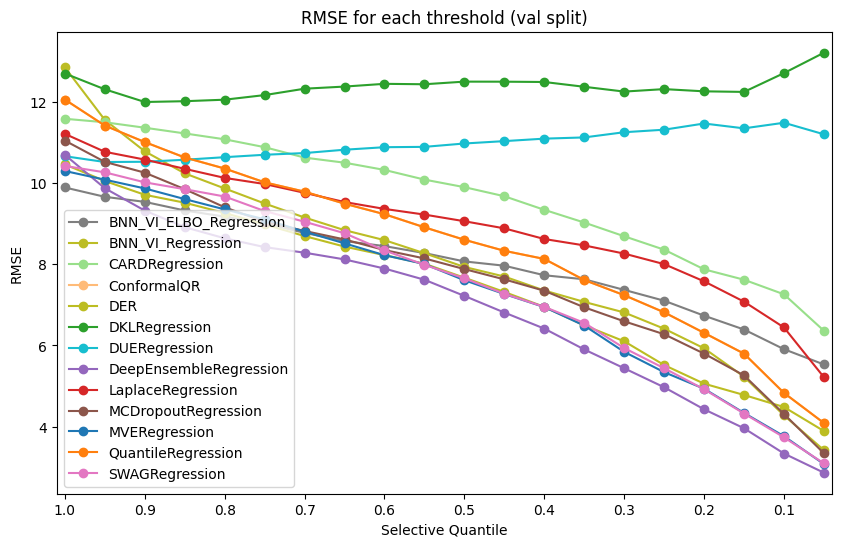

In [ ]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_df, DS_SPLIT):
    # Filter the DataFrame for the given DS_SPLIT
    split_df = rmse_df[rmse_df["split"] == f"preds_{DS_SPLIT}"]

    # Get the unique pred_paths
    pred_paths = split_df["pred_path"].unique()

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot a line for each pred_path
    for pred_path in pred_paths:
        path_df = split_df[split_df["pred_path"] == pred_path]
        method = path_df["uqmethod"].iloc[0]
        path_df = path_df.sort_values("threshold", ascending=False)
        plt.plot(
            path_df["threshold"],
            path_df["RMSE"],
            "o-",
            label=method,
            color=color_palette[method],
        )
    plt.xlim(max(path_df["threshold"]) + 0.01, min(path_df["threshold"]) - 0.01)
    start, end = plt.xlim()
    plt.xticks(
        np.arange(max(path_df["threshold"]), min(path_df["threshold"]), step=-0.1)
    ) 
    plt.xlabel("Selective Quantile")
    plt.ylabel("RMSE")
    plt.title(f"RMSE for each threshold ({DS_SPLIT} split)")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()


# Call the function
plot_rmse(rmse_df, "val")

## Dataframe with Metrics per Category

In [ ]:
import uncertainty_toolbox.metrics_calibration as uct_cal
import uncertainty_toolbox.metrics_scoring_rule as uct_score


def compute_metrics(all_test_pred_df, quantile=0.95):
    group_cols = ["uqmethod", "pred_path", "storm_category"]

    # Define the function to apply for MACE
    def apply_mace(group):
        return uct_cal.mean_absolute_calibration_error(
            group["pred"].values, group["pred_uct"].values, group["target"].values
        )

    # Apply the function to the grouped dataframe for MACE
    result_mace = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_mace)
        .reset_index()
    )
    result_mace.rename(columns={0: "mace"}, inplace=True)

    # Define the function to apply for CRPS
    def apply_crps(group):
        return uct_score.crps_gaussian(
            group["pred"].values, group["pred_uct"].values, group["target"].values
        )
    result_crps = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(apply_crps)
        .reset_index()
    )


    result_crps.rename(columns={0: "crps"}, inplace=True)

    
    category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[
        ["mse", "mae", "nll", "pred_uct"]
    ].mean()
    category_df = pd.merge(
        category_df, result_mace, how="left", left_on=group_cols, right_on=group_cols
    )
    category_df = pd.merge(
        category_df, result_crps, how="left", left_on=group_cols, right_on=group_cols
    )

    # Additional processing
    category_df.reset_index(inplace=True)
    category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
    category_df["rmse"] = category_df["mse"] ** 0.5
    category_df["split"] = (
        category_df["pred_path"].str.rsplit("/", n=1).str[-1].str.rsplit(".").str[0]
    )

    quantile = 0.9
    result = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(group_cols, observed=False)
        .apply(
            lambda x: uct.get_proportion_in_interval(
                x["pred"].values,
                x["pred_uct"].values,
                x["target"].values,
                quantile=quantile,
            )
        )
        .reset_index()
    )
    result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

    category_df = pd.merge(
        category_df, result, how="left", left_on=group_cols, right_on=group_cols
    )

    corr_one = "mae"
    corr_two = "pred_uct"
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{DS_SPLIT}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]

    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    print(corr_df)
    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )
    pivot_table.melt(), len(corr_df["uqmethod"].unique())

    final = pivot_table.melt()
    final["uqmethod"] = corr_df["uqmethod"].unique().tolist() * 8
    final.columns = ["storm_category", "correlation", "uqmethod"]

    category_df = category_df.merge(
        final, on=["uqmethod", "storm_category"], how="left"
    )

    columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
    category_df = category_df.dropna(subset=columns_to_check)

    category_df["storm_category"] = category_df["storm_category"].astype("category")

    return category_df


category_df = compute_metrics(all_test_pred_df)
category_df

/tmp/ipykernel_17901/1657068303.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_mace)
/tmp/ipykernel_17901/1657068303.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_crps)
/tmp/ipykernel_17901/1657068303.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns wi

                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.487311
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.487311  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.104884
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.104884  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.311363
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]


/tmp/ipykernel_17901/1657068303.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_17901/1657068303.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation
0,0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,70.712085,6.380909,4.595437,3.497677,0.230317,13.633803,8.409048,preds_test,0.543651,0.743655
1,1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,73.210300,6.722241,4.604114,4.381516,0.193139,24.907048,8.556302,preds_test,0.598483,0.552442
2,2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,220.048944,12.224621,7.991428,6.029948,0.267165,40.111166,14.834047,preds_test,0.462222,0.344319
3,3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,353.796518,15.875670,8.857412,7.418166,0.283384,50.095956,18.809479,preds_test,0.424936,0.277855
4,4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,643.302306,20.958924,13.652584,8.549606,0.299231,58.742428,25.363405,preds_test,0.398983,0.210824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,3544,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,186.492015,10.764282,4.092062,15.819826,0.050750,33.277115,13.656208,preds_val,0.925699,0.374319
3545,3545,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,171.217716,10.388270,4.016960,16.152649,0.069215,43.802431,13.085019,preds_val,0.956120,0.564114
3546,3546,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,166.825088,10.038276,3.996513,15.471406,0.070319,52.342257,12.916079,preds_val,0.940476,0.649080
3547,3547,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,347.152897,14.843803,4.364738,15.633476,0.057255,64.431130,18.632040,preds_val,0.849642,0.660919


In [ ]:
split = "test"
corr_one = "mae"
corr_two = "pred_uct"
filtered_df = all_test_pred_df[
    (all_test_pred_df["split"] == f"preds_{split}")
    & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
]

# Compute the correlation matrix
corr_df = (
    filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
    .apply(lambda group: group[[corr_one, corr_two]].corr())
    .reset_index()
)

print(corr_df)
# Compute the aggregate correlation
aggregate_corr_df = (
    filtered_df.groupby("uqmethod", observed=False)
    .apply(lambda group: group[[corr_one, corr_two]].corr())
    .reset_index()
)

# Add a 'storm_category' column to the aggregate correlation DataFrame
aggregate_corr_df["storm_category"] = "all"

# Append the aggregate correlation to the correlation DataFrame
corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

# Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
pivot_table = corr_df.pivot_table(
    index="uqmethod", columns="storm_category", values="mae"
)
pivot_table.melt(), len(corr_df["uqmethod"].unique())
# print(pivot_table.melt(id_vars=["uqmethod", "storm_category"], value_name="correlation"))
final = pivot_table.melt()
final["uqmethod"] = corr_df["uqmethod"].unique().tolist() * 8
final.columns = ["storm_category", "correlation", "uqmethod"]
final

                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.487311
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.487311  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.104884
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.104884  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.311363
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]


/tmp/ipykernel_17901/2529074253.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_17901/2529074253.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


,storm_category,correlation,uqmethod
0,H1,0.344319,BNN_VI_ELBO_Regression
1,H1,0.383822,CARDRegression
2,H1,0.423392,ConformalQR
3,H1,0.385275,DER
4,H1,0.461088,DKLRegression
...,...,...,...
91,all,0.614155,LaplaceRegression
92,all,0.665518,MCDropoutRegression
93,all,0.682375,MVERegression
94,all,0.675026,QuantileRegression


In [ ]:
corr_df["uqmethod"].unique().tolist() * 8

['BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression',
 'ConformalQR',
 'DER',
 'DKLRegression',
 'DUERegression',
 'DeepEnsembleRegression',
 'LaplaceRegression',
 'MCDropoutRegression',
 'MVERegression',
 'QuantileRegression',
 'SWAGRegression',
 'BNN_VI_ELBO_Regression',
 'CARDRegression'

In [ ]:
with pd.option_context("display.max_colwidth", None):
    display(category_df[category_df["uqmethod"] == "DKLRegression"])

,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation
1176,1176,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TD,92.291948,7.327655,3.755604,12.955040,0.113080,9.800298,9.606870,preds_test,0.973029,0.548170
1177,1177,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TS,132.055877,8.423561,3.887062,13.125434,0.085241,19.917808,11.491557,preds_test,0.939685,0.449134
1178,1178,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H1,293.895942,14.476544,4.358168,13.718709,0.113394,34.910315,17.143394,preds_test,0.789240,0.461088
1179,1179,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H2,399.742069,16.765970,4.542413,13.574875,0.158461,45.532103,19.993551,preds_test,0.683842,0.768701
1180,1180,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H3,484.243288,17.986463,4.776416,13.219712,0.176436,54.294461,22.005529,preds_test,0.652478,0.812515
1181,1181,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H4,233.682156,11.038174,4.172190,13.005219,0.024829,65.162830,15.286666,preds_test,0.872204,0.506023
1182,1182,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H5,369.309979,17.540630,4.535181,13.387369,0.257005,78.069890,19.217439,preds_test,0.843537,0.635343
1183,1183,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TD,77.976933,7.019707,3.710547,12.941712,0.118890,9.984380,8.830455,preds_train,0.985240,0.548170
1184,1184,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TS,108.103654,7.662263,3.811378,13.050349,0.110812,19.816201,10.397291,preds_train,0.949929,0.449134
1185,1185,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,H1,213.549206,12.323096,4.117912,13.557479,0.063768,34.913924,14.613323,preds_train,0.878245,0.461088


In [ ]:
# Make latex table
def generate_latex_table(category_df, split_type):
    metric_columns = ["rmse", "nll"]

    table_labels = category_df["storm_category"].unique()
    columns = pd.MultiIndex.from_product([table_labels, metric_columns])
    combined_df = pd.DataFrame(columns=columns)

    latex_df = category_df[category_df["split"] == f"preds_{split_type}"]
    print(latex_df)

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    latex_df["uqmethod"] = latex_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    for split in table_labels:
        split_df = latex_df[latex_df["storm_category"] == split]
        for metric in metric_columns:
            combined_df[(split, metric)] = split_df[metric].values

    combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
    combined_df = combined_df.round(3)

    latex_table = as_latex_output(combined_df)
    return latex_table


def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
            
    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output


latex_table = generate_latex_table(category_df, DS_SPLIT)
print(latex_table)

      index                uqmethod  \
0         0  BNN_VI_ELBO_Regression   
1         1  BNN_VI_ELBO_Regression   
2         2  BNN_VI_ELBO_Regression   
3         3  BNN_VI_ELBO_Regression   
4         4  BNN_VI_ELBO_Regression   
...     ...                     ...   
3530   3530          SWAGRegression   
3531   3531          SWAGRegression   
3532   3532          SWAGRegression   
3533   3533          SWAGRegression   
3534   3534          SWAGRegression   

                                              pred_path storm_category  \
0     /p/project/hai_uqmethodbox/experiment_output/m...             TD   
1     /p/project/hai_uqmethodbox/experiment_output/m...             TS   
2     /p/project/hai_uqmethodbox/experiment_output/m...             H1   
3     /p/project/hai_uqmethodbox/experiment_output/m...             H2   
4     /p/project/hai_uqmethodbox/experiment_output/m...             H3   
...                                                 ...            ...   
3530  /p/proj

/tmp/ipykernel_17901/3256025416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latex_df["uqmethod"] = latex_df["uqmethod"].apply(


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{TD} & \multicolumn{2}{c}{TS} & \multicolumn{2}{c}{H1} & \multicolumn{2}{c}{H2} & \multicolumn{2}{c}{H3} & \multicolumn{2}{c}{H4} & \multicolumn{2}{c}{H5} \\
uqmethod & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ \\
\midrule
\textbf{BNN VI ELBO} & 8.409 & 4.595 & \textbf{8.556} & 4.604 & 14.834 & 7.991 & 18.809 & 8.857 & 25.363 & 13.653 & 29.395 & 10.906 & 40.736 & 11.105 \\
CARD & 7.146 & 3.265 & 10.090 & 4.029 & 15.423 & 4.794 & 16.622 & 4.858 & 19.077 & 5.329 & 17.497 & 4.785 & 24.322 & 6.378 \\
CQR & 8.294 & 3.525 & 9.690 & 3.796 & 15.350 & 4.199 & 16.635 & 4.280 & 17.972 & 4.430 & 17.401 & 4.345 & 27.543 & 4.934 \\
DER & 7.574 & 4.429 & 9.124 & 4.647 & 14.778 & 4.800 & 15.178 & 4.800 & 16.553 & 4

/tmp/ipykernel_17901/3288030592.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_cat_df["storm_category"] = pd.Categorical(
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` t

mae
mae
proportion_in_0.9_interval
nll
nll


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

sharpness
sharpness
mace
mace
correlation


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

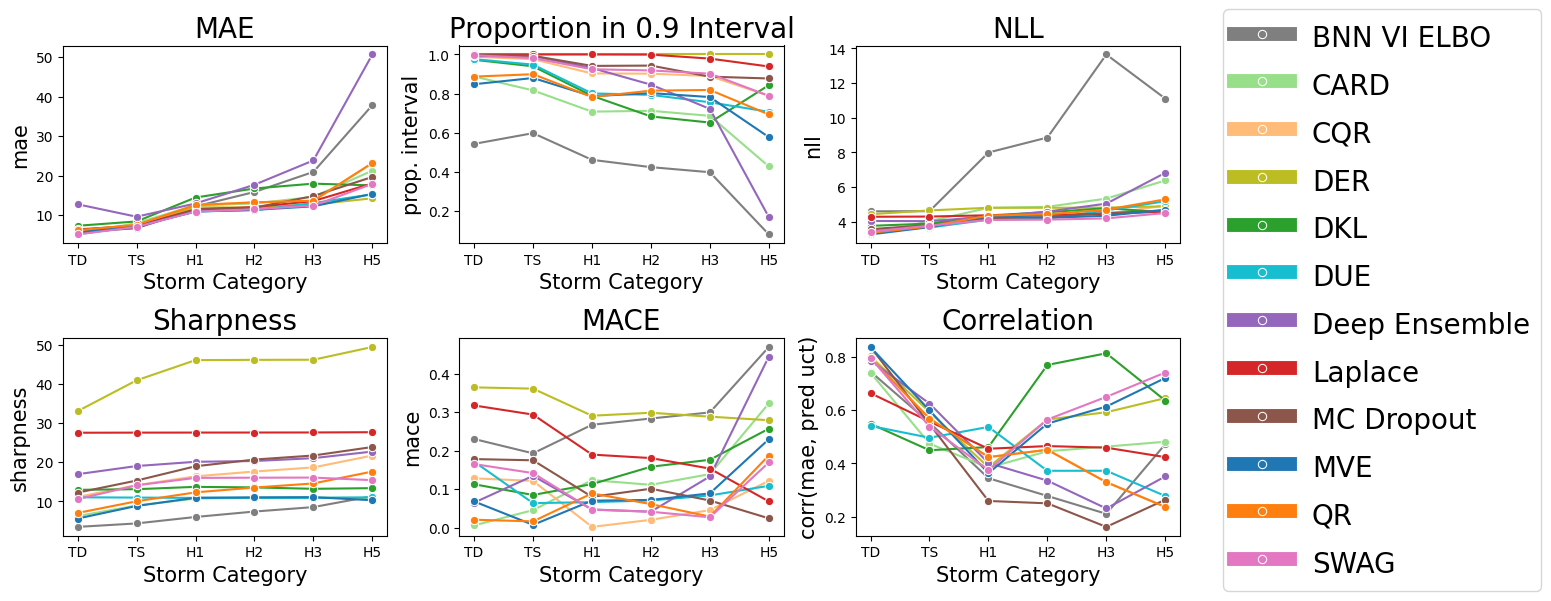

In [ ]:
def plot_metrics_by_category(category_df, split_type):
    plot_cat_df = category_df[category_df["split"] == f"preds_{split_type}"]

    # plot per category
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))

    # Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
    metrics = [
        "mae",
        "proportion_in_0.9_interval",
        "nll",
        "sharpness",
        "mace",
        "correlation",
    ]

    plot_cat_df["storm_category"] = pd.Categorical(
        plot_cat_df["storm_category"], categories=STORM_DISPLAY_ORDER, ordered=True
    )

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df[
        "storm_category"
    ].cat.remove_unused_categories()

    # Loop through the subplots
    for i, metric in enumerate(metrics):
        row = i // 3
        col = i % 3

        # Create the sns plot
        sns.lineplot(
            x="storm_category",
            y=metric,
            hue="uqmethod",
            data=plot_cat_df,
            ax=axes[row, col],
            marker="o",
            palette=color_palette,
        )

        axes[row, col].set_title(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)

        axes[row, col].set_xlabel("Storm Category", fontsize=15)
        print(metric)
        if "proportion" in metric:
            axes[row, col].set_ylabel("prop. interval", fontsize=15)
        elif metric == "correlation":
            axes[row, col].set_ylabel("corr(mae, pred uct)", fontsize=15)
        else:
            print(metric)
            axes[row, col].set_ylabel(metric, fontsize=15)

        axes[row, col].tick_params(axis="both", which="major", labelsize=10)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    labels = [
        VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label
        for label in labels
    ]

    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.3, 0.5),
        fontsize=20,
        handleheight=1.5,
    )

    for ax in axes.flat:
        ax.get_legend().remove()
    plt.tight_layout()
    plt.show()

plot_metrics_by_category(category_df, DS_SPLIT)

In [ ]:
correlations_df = (
    category_df.groupby(["uqmethod", "storm_category"])
    .apply(lambda x: x["mae"].corr(x["sharpness"]))
    .reset_index()
)
correlations_df.columns = ["uqmethod", "storm_category", "calibration"]

category_df = category_df.merge(
    correlations_df, on=["uqmethod", "storm_category"], how="left"
)
category_df

/tmp/ipykernel_17901/3493269393.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlations_df = category_df.groupby(['uqmethod', 'storm_category']).apply(lambda x: x['mae'].corr(x['sharpness'])).reset_index()
/tmp/ipykernel_17901/3493269393.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_df = category_df.groupby(['uqmethod', 'storm_category']).apply(lambda x: x['mae'].corr(x['sharpness'])).reset_index()


,index,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,mace,crps,rmse,split,proportion_in_0.9_interval,correlation,calibration
0,0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,70.712085,6.380909,4.595437,3.497677,0.230317,13.633803,8.409048,preds_test,0.543651,0.743655,0.229413
1,1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,73.210300,6.722241,4.604114,4.381516,0.193139,24.907048,8.556302,preds_test,0.598483,0.552442,0.811330
2,2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,220.048944,12.224621,7.991428,6.029948,0.267165,40.111166,14.834047,preds_test,0.462222,0.344319,-0.021042
3,3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,353.796518,15.875670,8.857412,7.418166,0.283384,50.095956,18.809479,preds_test,0.424936,0.277855,-0.167792
4,4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,643.302306,20.958924,13.652584,8.549606,0.299231,58.742428,25.363405,preds_test,0.398983,0.210824,-0.969512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,3544,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,186.492015,10.764282,4.092062,15.819826,0.050750,33.277115,13.656208,preds_val,0.925699,0.374319,-0.581982
248,3545,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,171.217716,10.388270,4.016960,16.152649,0.069215,43.802431,13.085019,preds_val,0.956120,0.564114,0.324114
249,3546,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,166.825088,10.038276,3.996513,15.471406,0.070319,52.342257,12.916079,preds_val,0.940476,0.649080,0.901267
250,3547,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,347.152897,14.843803,4.364738,15.633476,0.057255,64.431130,18.632040,preds_val,0.849642,0.660919,0.542341


# Tables

## RMSE Overview Table

In [ ]:
def generate_latex_table(uq_metric_df, selective_df, split_type):
    category_columns = ["rmse", "crps", "nll", "ma_cal"]

    combined_df = pd.DataFrame(columns=category_columns)

    table_uq_df = uq_metric_df[uq_metric_df["split"] == f"preds_{split_type}"]
    table_selective_df = selective_df[selective_df["split"] == f"preds_{split_type}"]

    table_uq_df["uqmethod"] = pd.Categorical(
        table_uq_df["uqmethod"], categories=UQ_METHOD_DISPLAY_ORDER, ordered=True
    )

    for metric in category_columns:
        
        combined_df[(metric)] = table_uq_df[metric]
        if "rmse" == metric:
            diff_rmse = table_uq_df[metric] - table_selective_df[metric]
            combined_df.insert(
                combined_df.columns.get_loc(metric) + 1, "diff rmse", diff_rmse
            )
            coverage = table_selective_df["count_total"] / table_uq_df["count_total"]
            combined_df.insert(
                combined_df.columns.get_loc("diff rmse") + 1, "coverage", coverage
            )

    combined_df.insert(0, ("uqmethod"), table_uq_df["uqmethod"])
    combined_df = combined_df.round(2)

    combined_df = combined_df.sort_values("uqmethod")

    combined_df["group"] = combined_df["uqmethod"].apply(
        lambda x: next((k for k, v in UQ_METHOD_GROUPS.items() if x in v), "None")
    )

    combined_df = combined_df[
        ["group"] + [col for col in combined_df.columns if col != "group"]
    ]

    combined_df["uqmethod"] = combined_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    print(combined_df)
    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table


def as_latex_output(combined_df, category_columns):
    """Format latex output"""
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()

    # Replace the group names with the \multirow command
    for group in UQ_METHOD_GROUPS.keys():
        num_rows = len(combined_df[combined_df["group"] == group])
        group_indices = combined_df[combined_df["group"] == group].index
        if len(group_indices) > 0:
            first_index = group_indices[0]
            combined_df.at[first_index, "group"] = (
                r"\multirow{" + str(num_rows) + "}{*}{" + group + "}"
            )
            for index in group_indices[1:]:
                combined_df.at[index, "group"] = ""

    # convert to latex
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.2f")

    # bold face column values
    min_cols = ["rmse", "crps", "nll", "ma_cal"]
    max_cols = ["diff rmse", "coverage"]
    for column in max_values.index:
        if column in max_cols:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        elif column in min_cols:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        else:
            continue

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(
            column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column
        )

    # other formatting
    latex_output = latex_output.replace("\\multirow", "\\midrule\n\\multirow")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("RMSE", "RMSE $\downarrow$")
    latex_output = latex_output.replace(
        "diff RMSE $\downarrow$", r"RMSE $\Delta$ $\uparrow$"
    )
    latex_output = latex_output.replace("NLL", "NLL $\downarrow$")
    latex_output = latex_output.replace("ma_cal", "MACE $\downarrow$")
    latex_output = latex_output.replace("coverage", r"Coverage $\uparrow$")
    latex_output = latex_output.replace("CRPS", "CRPS $\downarrow$")

    latex_output = latex_output.replace("group", "UQ group")
    latex_output = latex_output.replace("uqmethod", "Method")

    return latex_output


latex_table = generate_latex_table(uq_metric_df, selective_df, DS_SPLIT)
print(latex_table)

/tmp/ipykernel_17901/919811205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_uq_df["uqmethod"] = pd.Categorical(


            group       uqmethod   rmse  diff rmse  coverage   crps   nll  \
16           None  Deterministic  10.50       0.00      1.00    NaN   NaN   
37  Deterministic            MVE   9.95       2.10      0.62   5.31  3.64   
34  Deterministic            DER  10.14        NaN      0.00  10.07  4.60   
7        Quantile             QR  10.95       3.28      0.44   5.82  3.73   
19       Quantile            CQR  10.95       6.18      0.08   5.98  3.79   
10       Ensemble  Deep Ensemble  16.19        NaN      0.00   8.83  4.15   
31       Bayesian     MC Dropout  10.23       6.12      0.00   5.78  3.81   
22       Bayesian           SWAG   9.78       5.42      0.11   5.40  3.71   
25       Bayesian        Laplace  10.53        NaN      0.00   7.96  4.31   
1        Bayesian    BNN VI ELBO  11.82       0.55      0.95   6.70  5.57   
4        Bayesian            DKL  12.59        NaN      0.00   6.84  3.95   
13       Bayesian            DUE   9.95        NaN      0.00   5.43  3.73   

In [ ]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,6.103769,7.847798,3.954027,52.394716,0.268295,0.238872,0.241285,5.421247,9.799408,14.106796,...,/p/project/hai_uqmethodbox/experiment_output/m...,3123,4557,1147,433,582,426,67,10335,BNN_VI_ELBO_Regression
1,5.569881,6.702274,3.378063,43.197575,0.254217,0.226616,0.228905,5.064225,8.489873,11.819448,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,BNN_VI_ELBO_Regression
2,2.812489,2.574237,1.299864,12.424515,0.030920,0.023962,0.024204,5.363565,3.719906,5.247028,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,BNN_VI_ELBO_Regression
3,3.949773,6.848777,3.457718,35.533872,0.064776,0.056251,0.056815,13.124806,9.342684,12.698880,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,DKLRegression
4,3.948189,6.840202,3.453518,35.380966,0.065011,0.055761,0.056318,13.164921,9.340257,12.586209,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DKLRegression
5,3.861324,6.293967,3.177965,32.147210,0.082573,0.072472,0.073201,13.120582,8.623980,11.356123,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,DKLRegression
6,3.799299,6.286635,3.173897,31.935729,0.011250,0.009324,0.009407,10.764476,8.758050,12.056662,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,QuantileRegression
7,3.727799,5.819242,2.938107,29.226522,0.015484,0.013569,0.013706,10.136679,8.145264,10.954583,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,QuantileRegression
8,3.676418,5.581838,2.818391,27.804535,0.018004,0.016157,0.016316,10.689566,7.831585,10.398647,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,QuantileRegression
9,3.882303,6.062069,3.060785,32.794904,0.204953,0.183441,0.185294,16.725277,7.621405,10.694744,...,/p/project/hai_uqmethodbox/experiment_output/m...,3123,4557,1147,433,582,426,67,10335,DeepEnsembleRegression


## Metric Computation per Category

In [ ]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product(
    [splits, category_columns, ["default", "selective", "diff"]]
)
combined_df = pd.DataFrame(columns=columns)

## Error Analysis per Category

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/min

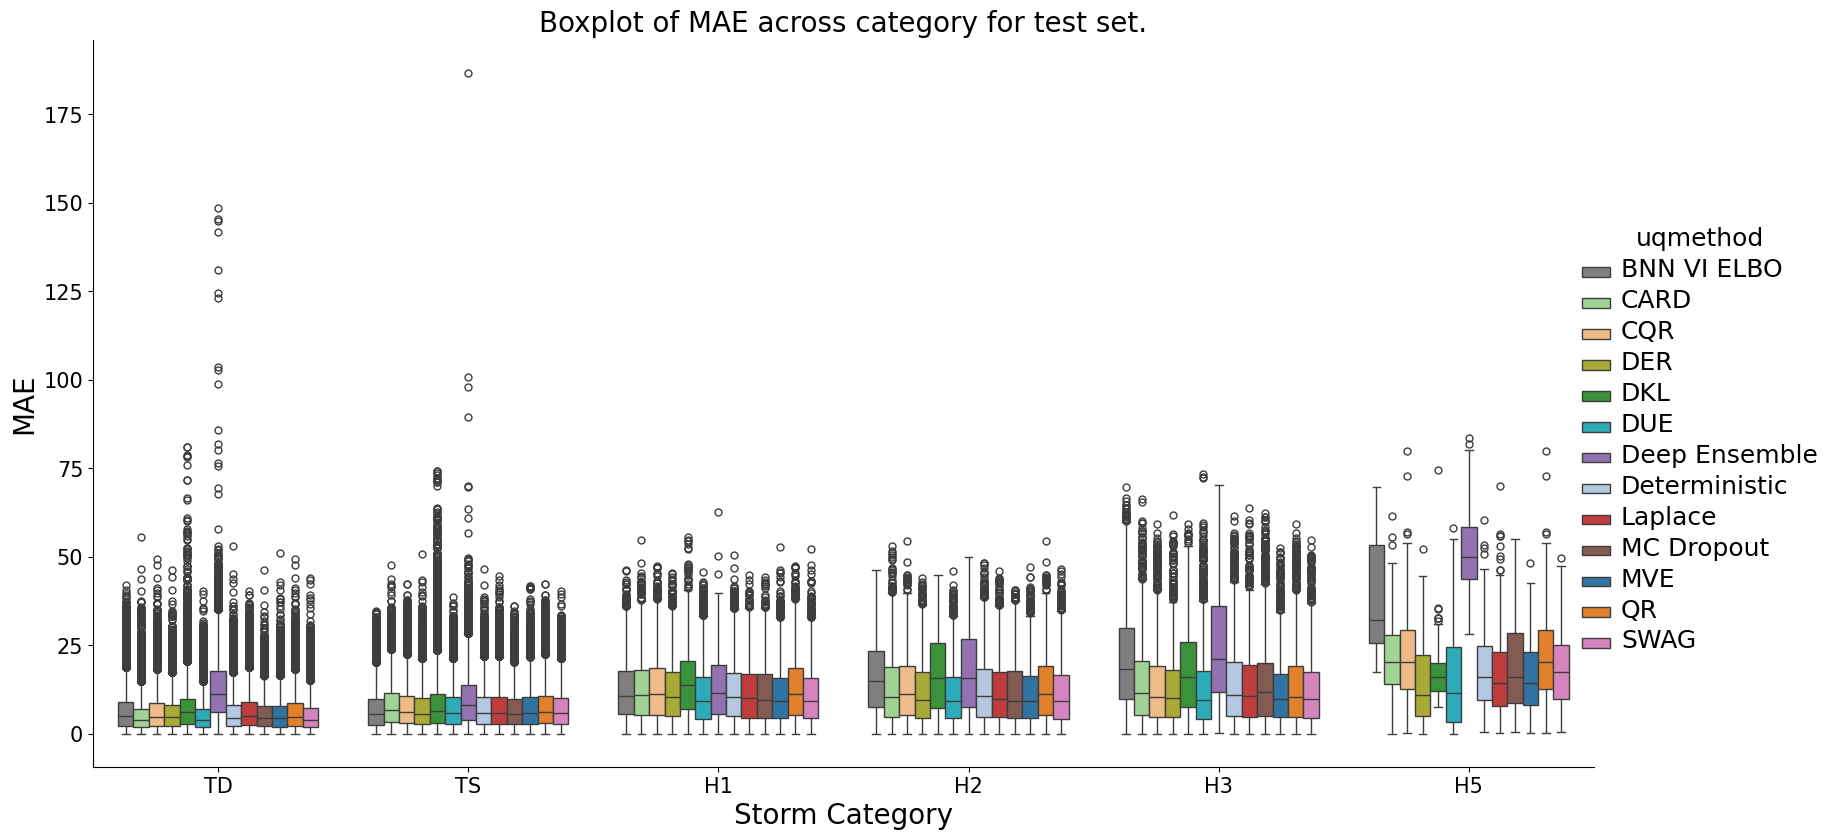

In [ ]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()

    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax


    for i, artist in enumerate(ax.artists):
        if i % 2 == 0: 
            artist.set_edgecolor("black")

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

# Selective prediction per Storm Category

In [ ]:
from sklearn.metrics import mean_squared_error


def generate_summary_table(all_test_pred_df, split):
    # Compute RMSE for all samples per uqmethod
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "RMSE_All"]

    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "RMSE_All"]

    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    rmse_all_samples_filtered = (
        df_filtered.groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples_filtered.columns = ["uqmethod", "RMSE_Uncertainty_Less_Threshold"]

    rmse_all_samples_filtered["storm_category"] = "all"

    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "RMSE_Uncertainty_Less_Threshold",
    ]

    rmse_filtered = pd.concat(
        [rmse_filtered, rmse_all_samples_filtered], ignore_index=True
    )

    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    summary_table.fillna({"RMSE_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"])
        / summary_table["RMSE_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


# Call the function with 'val' or 'train' as the argument
summary_table = generate_summary_table(all_test_pred_df, DS_SPLIT)
print(summary_table)

/tmp/ipykernel_17901/2458153804.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
/tmp/ipykernel_17901/2458153804.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))


                   uqmethod storm_category   RMSE_All  \
0    BNN_VI_ELBO_Regression             TD   8.409048   
1    BNN_VI_ELBO_Regression             TS   8.556302   
2    BNN_VI_ELBO_Regression             H1  14.834047   
3    BNN_VI_ELBO_Regression             H2  18.809479   
4    BNN_VI_ELBO_Regression             H3  25.363405   
..                      ...            ...        ...   
99        LaplaceRegression            all  10.527570   
100     MCDropoutRegression            all  10.229750   
101           MVERegression            all   9.947039   
102      QuantileRegression            all  10.954583   
103          SWAGRegression            all   9.779521   

     RMSE_Uncertainty_Less_Threshold  pct_change  abs_change  
0                           6.533213  -22.307345    1.875835  
1                           6.295241  -26.425676    2.261061  
2                          10.973861  -26.022472    3.860186  
3                          14.482923  -23.001999    4.326556  


/tmp/ipykernel_17901/2458153804.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_17901/2458153804.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
/tmp/ipykernel_17901/2458153804.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future v

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

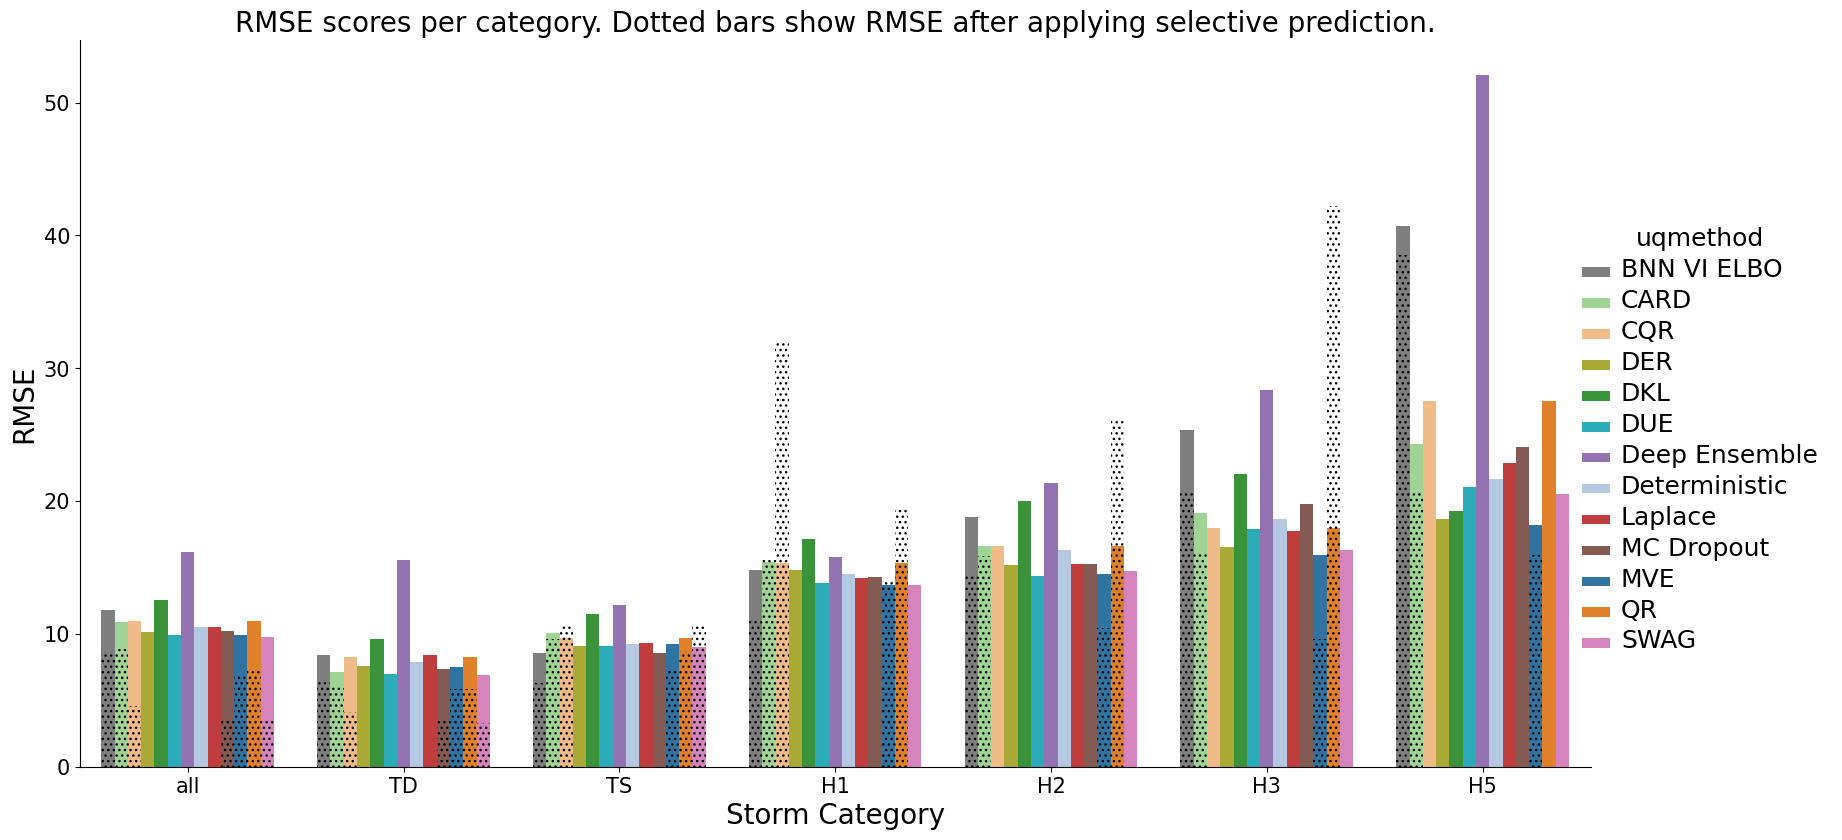

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_bar(summary_table):
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    hue_order = summary_table["uqmethod"].unique().tolist()


    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    g = sns.catplot(
        data=summary_table,
        kind="bar",
        x="storm_category",
        y="RMSE_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="RMSE_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )
    plt.title(
        "RMSE scores per category. Dotted bars show RMSE after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    plt.setp(g._legend.get_texts(), fontsize="18")
    plt.setp(g._legend.get_title(), fontsize="18") 
    g._legend.set_bbox_to_anchor((1.0, 0.5))


plot_bar(summary_table)

In [ ]:
def compute_summary(all_test_pred_df, split):
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "SHARP_All"]

    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "SHARP_All"]

    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    # Compute RMSE per method and category over filtered predictions
    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "SHARP_Uncertainty_Less_Threshold",
    ]

    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    summary_table.fillna({"SHARP_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"])
        / summary_table["SHARP_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


summary_table = compute_summary(all_test_pred_df, DS_SPLIT)

/tmp/ipykernel_17901/3457675125.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(x["pred_uct"]))
/tmp/ipykernel_17901/3457675125.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(x["pred_uct"]))


/tmp/ipykernel_17901/3457675125.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/tmp/ipykernel_17901/3457675125.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(x["pred_uct"]))


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data

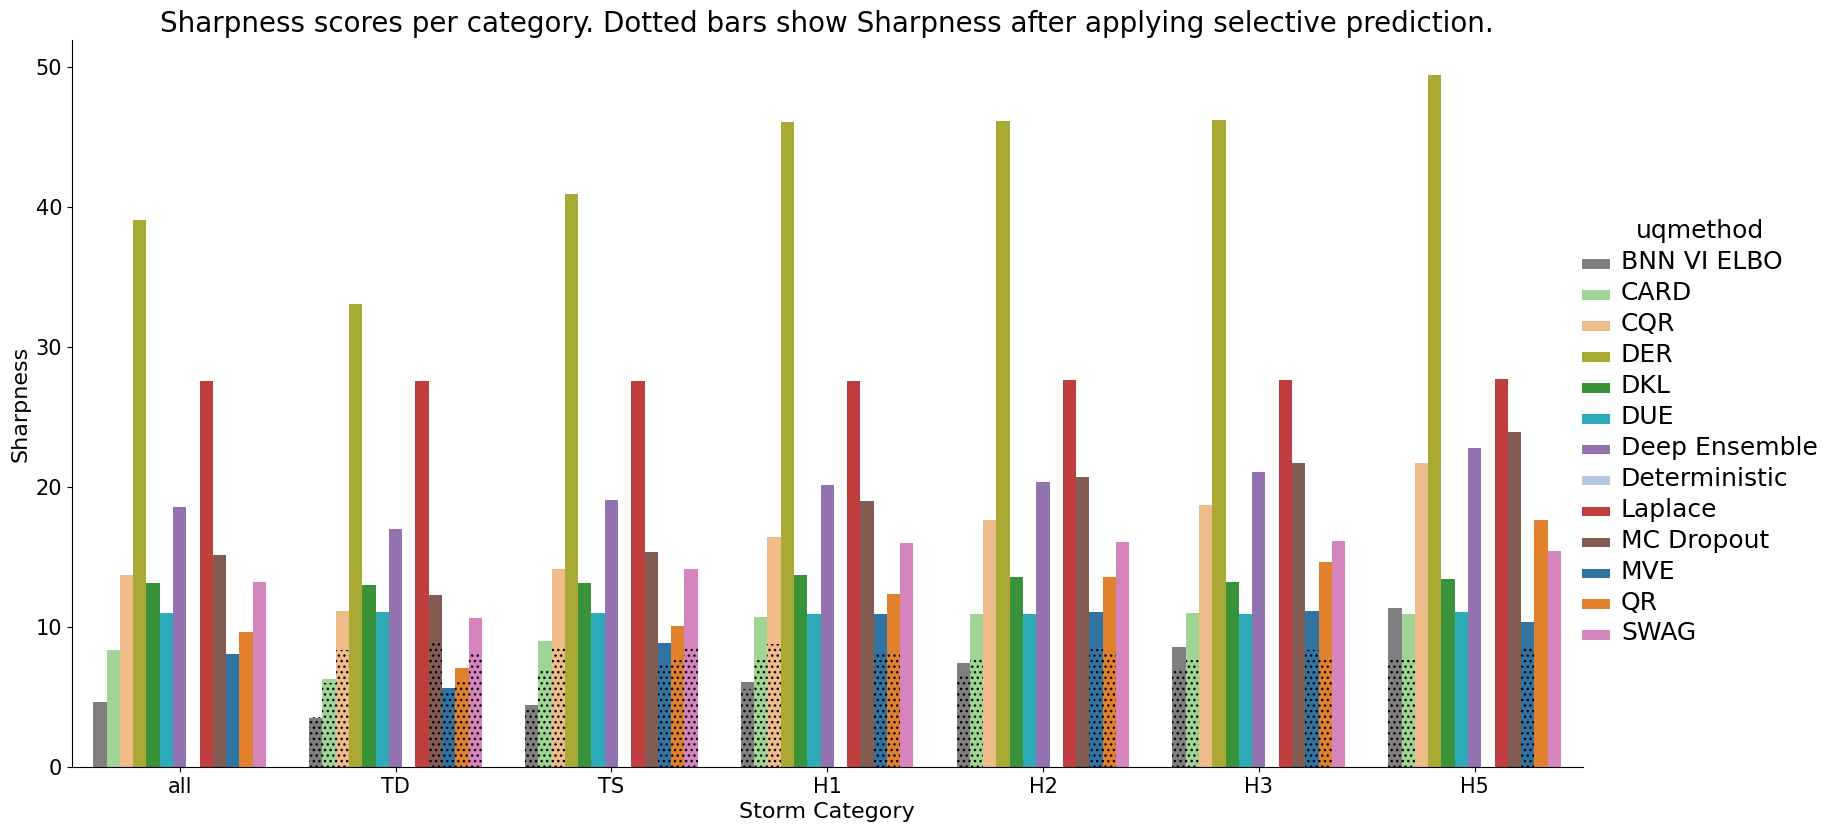

In [ ]:
def plot_sharpness(summary_table):
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")
    hue_order = (
        summary_table[summary_table["uqmethod"] != "DERModel"]["uqmethod"]
        .unique()
        .tolist()
    )
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()
    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    g = sns.catplot(
        data=summary_table[summary_table["uqmethod"] != "DERModel"],
        kind="bar",
        x="storm_category",
        y="SHARP_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="SHARP_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        "Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("Sharpness", fontsize=16)
    plt.xlabel("Storm Category", fontsize=16)
    plt.setp(g._legend.get_texts(), fontsize="18") 
    plt.setp(g._legend.get_title(), fontsize="18") 
    g._legend.set_bbox_to_anchor((1.0, 0.5))


plot_sharpness(summary_table)

# Calibration

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/p/project/hai_uqmethodbox/min

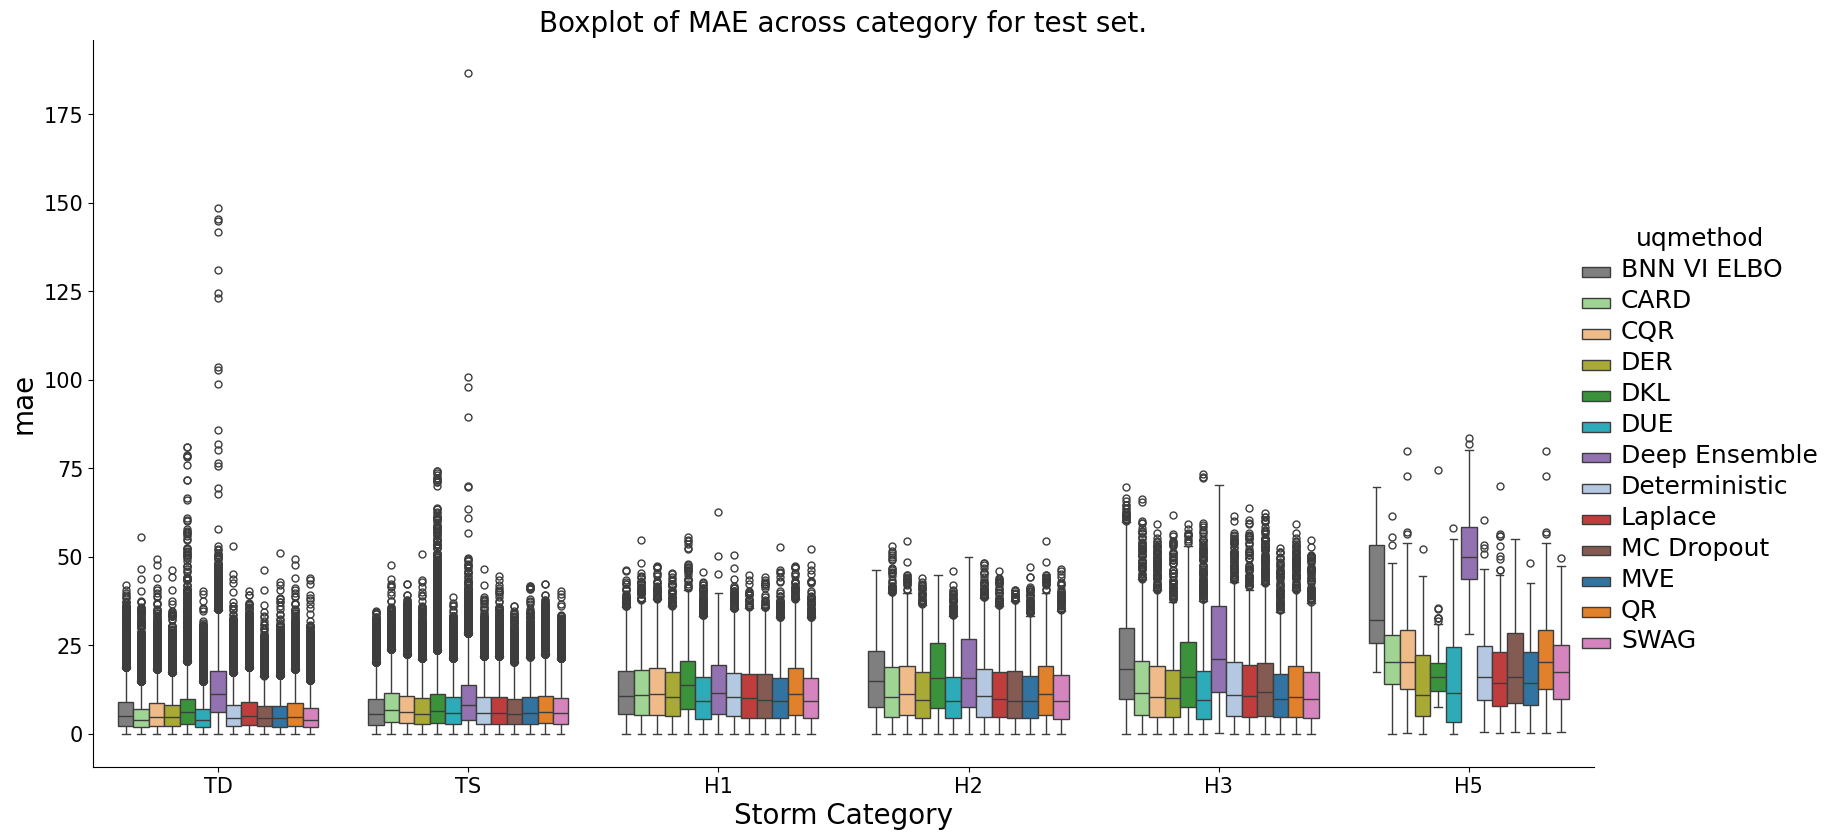

In [ ]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax

    for i, artist in enumerate(ax.artists):
        if i % 2 == 0: 
            artist.set_edgecolor("black") 


    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{metric}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize="18") 
    plt.setp(g._legend.get_title(), fontsize="18")
    g._legend.set_bbox_to_anchor((1.0, 0.5))


plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

In [ ]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions,
        obs_proportions,
        label=curve_label.replace("Model", ""),
        c=color_palette[curve_label],
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )


    return ax

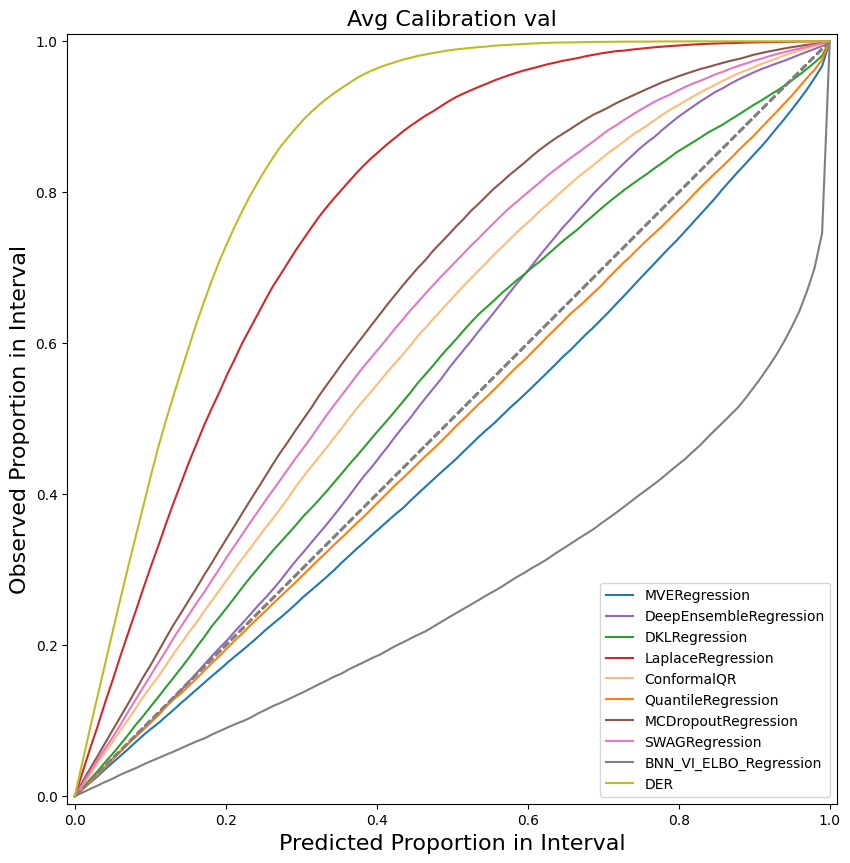

In [ ]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10, 10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    plot_df = plot_df[plot_df["split"] == f"preds_{DS_SPLIT}"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split,
            )
plt.legend()

# Correlation between Predictive Uncertainty and Errors

/tmp/ipykernel_17901/3259758472.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())
/tmp/ipykernel_17901/3259758472.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group[[corr_one, corr_two]].corr())


                   uqmethod storm_category   level_2       mae  pred_uct
0    BNN_VI_ELBO_Regression             TD       mae  1.000000  0.487311
1    BNN_VI_ELBO_Regression             TD  pred_uct  0.487311  1.000000
2    BNN_VI_ELBO_Regression             TS       mae  1.000000  0.104884
3    BNN_VI_ELBO_Regression             TS  pred_uct  0.104884  1.000000
4    BNN_VI_ELBO_Regression             H1       mae  1.000000 -0.311363
..                      ...            ...       ...       ...       ...
163          SWAGRegression             H3  pred_uct  0.298160  1.000000
164          SWAGRegression             H4       mae  1.000000  0.321837
165          SWAGRegression             H4  pred_uct  0.321837  1.000000
166          SWAGRegression             H5       mae  1.000000  0.480818
167          SWAGRegression             H5  pred_uct  0.480818  1.000000

[168 rows x 5 columns]
                   uqmethod storm_category   level_2       mae  pred_uct  \
0    BNN_VI_ELBO_Regress

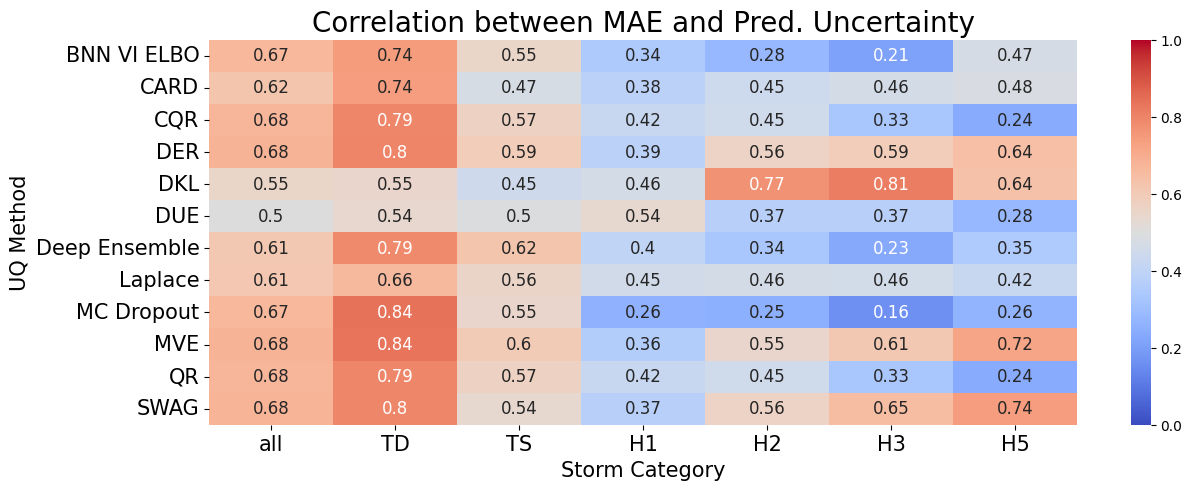

In [ ]:
def plot_correlation_heatmap(all_test_pred_df, split, corr_one, corr_two):
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{split}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]

    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    print(corr_df)
    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    aggregate_corr_df["storm_category"] = "all"

    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    print(corr_df)

    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )
    print(pivot_table)

    pivot_table = pivot_table.reindex(STORM_DISPLAY_ORDER, axis=1)

    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        annot_kws={"fontsize": 12},
    )


    plt.title(
        f"Correlation between {VAR_TO_PLOT_LABEL[corr_one]} and {VAR_TO_PLOT_LABEL[corr_two]}",
        fontsize=20,
    )
    plt.xlabel("Storm Category", fontsize=15)
    plt.ylabel("UQ Method", fontsize=15)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Replace the y-tick labels using the VAR_TO_PLOT_LABEL dictionary
    yticklabels = [
        (
            VAR_TO_PLOT_LABEL[label.get_text()]
            if label.get_text() in VAR_TO_PLOT_LABEL
            else label.get_text()
        )
        for label in plt.gca().get_yticklabels()
    ]
    plt.gca().set_yticklabels(yticklabels)

    plt.show()


plot_correlation_heatmap(all_test_pred_df, DS_SPLIT, "mae", "pred_uct")

              pred   pred_uct  epistemic_uct      target           uqmethod  \
884526  120.444204  27.606233       0.112764  136.999998  LaplaceRegression   
884527  121.650196  27.644749       0.125218  138.000001  LaplaceRegression   
884528  122.460067  27.653548       0.127896  138.000001  LaplaceRegression   
884529  119.261284  27.638553       0.123300  138.999998  LaplaceRegression   
884530  119.545223  27.623098       0.118377  140.000000  LaplaceRegression   
...            ...        ...            ...         ...                ...   
925025  122.368786  27.604625       0.112216  140.000000  LaplaceRegression   
925026  126.619305  27.611622       0.114588  140.000000  LaplaceRegression   
925027  125.024878  27.639430       0.123572  140.000000  LaplaceRegression   
925028  121.738036  27.654692       0.128241  138.000001  LaplaceRegression   
925029  124.848051  27.588312       0.106481  136.999998  LaplaceRegression   

             split                                 

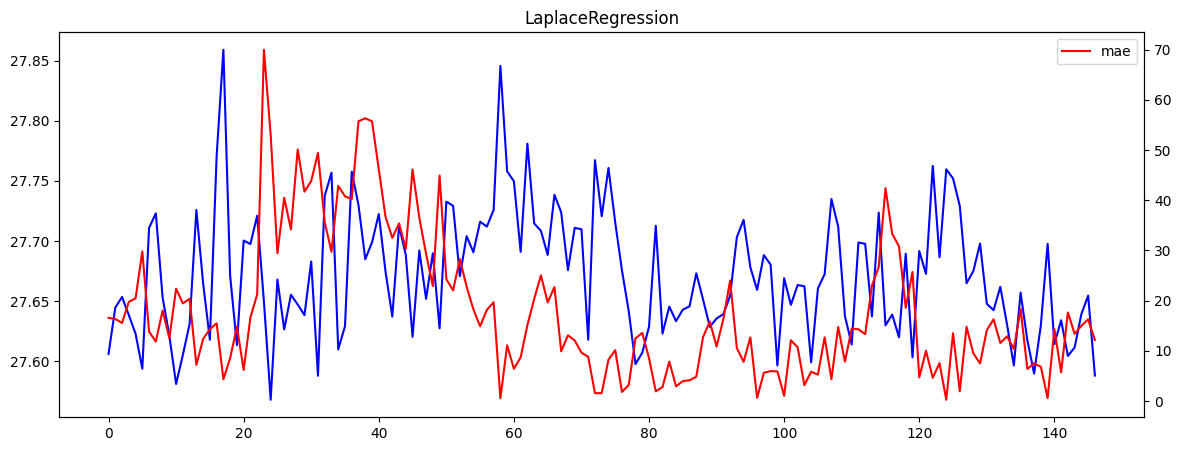

In [ ]:
method = "LaplaceRegression"

test_df_split = all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
test_df_split = test_df_split[test_df_split["storm_category"] == "H5"]
test_df_split = test_df_split[test_df_split["uqmethod"] == method]
print(test_df_split)

left = "pred_uct"
right = "mae"
plt.plot(range(len(test_df_split)), test_df_split[left], color="blue", label=left)
plt.twinx()
plt.plot(range(len(test_df_split)), test_df_split[right], color="red", label=right)
plt.title(method)
plt.legend()

In [ ]:
DS_SPLIT

'test'

# Track Prediction Visualization

In [22]:
# get a config from the overview_df
config = OmegaConf.load(os.path.join(os.path.dirname(dir_paths[0]), "config.yaml"))
datamodule = instantiate(config.datamodule)
datamodule.setup(stage="fit")
datamodule.setup(stage="test")

In [23]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))

101343
64500
14031
2801
20011


(None, None, None, None, None)

In [26]:
import uncertainty_toolbox.metrics_calibration as uct_cal
import uncertainty_toolbox.metrics_scoring_rule as uct_score

DS_SPLIT = "test"

# compute average error per track, and add a column that denotes the number of samples per storm_id
error_by_storm_id = (
    all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
    .groupby(["storm_id"], observed=False)
    .apply(lambda x: np.mean(np.abs(x["pred"].values - x["target"].values)))
    .reset_index()
)
error_by_storm_id.columns = ["storm_id", "error"]
unique_samples_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{DS_SPLIT}"
].drop_duplicates(subset=["storm_id", "relative_time"])

error_by_storm_id["n_samples"] = (
    unique_samples_df.groupby(["storm_id"], observed=False)
    .apply(lambda x: len(x))
    .values
)

error_by_storm_id.sort_values(by="error", inplace=True)

error_by_storm_id = error_by_storm_id[error_by_storm_id["n_samples"] > 50].reset_index(
    drop=True
)
first_and_last_ten = pd.concat(
    [error_by_storm_id.iloc[:10], error_by_storm_id.iloc[-10:]]
)


bottom_id = error_by_storm_id.iloc[-1]["storm_id"]
top_id = error_by_storm_id.iloc[0]["storm_id"]



/tmp/ipykernel_30320/433516172.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.mean(np.abs(x["pred"].values - x["target"].values)))


KeyError: Index(['relative_time'], dtype='object')

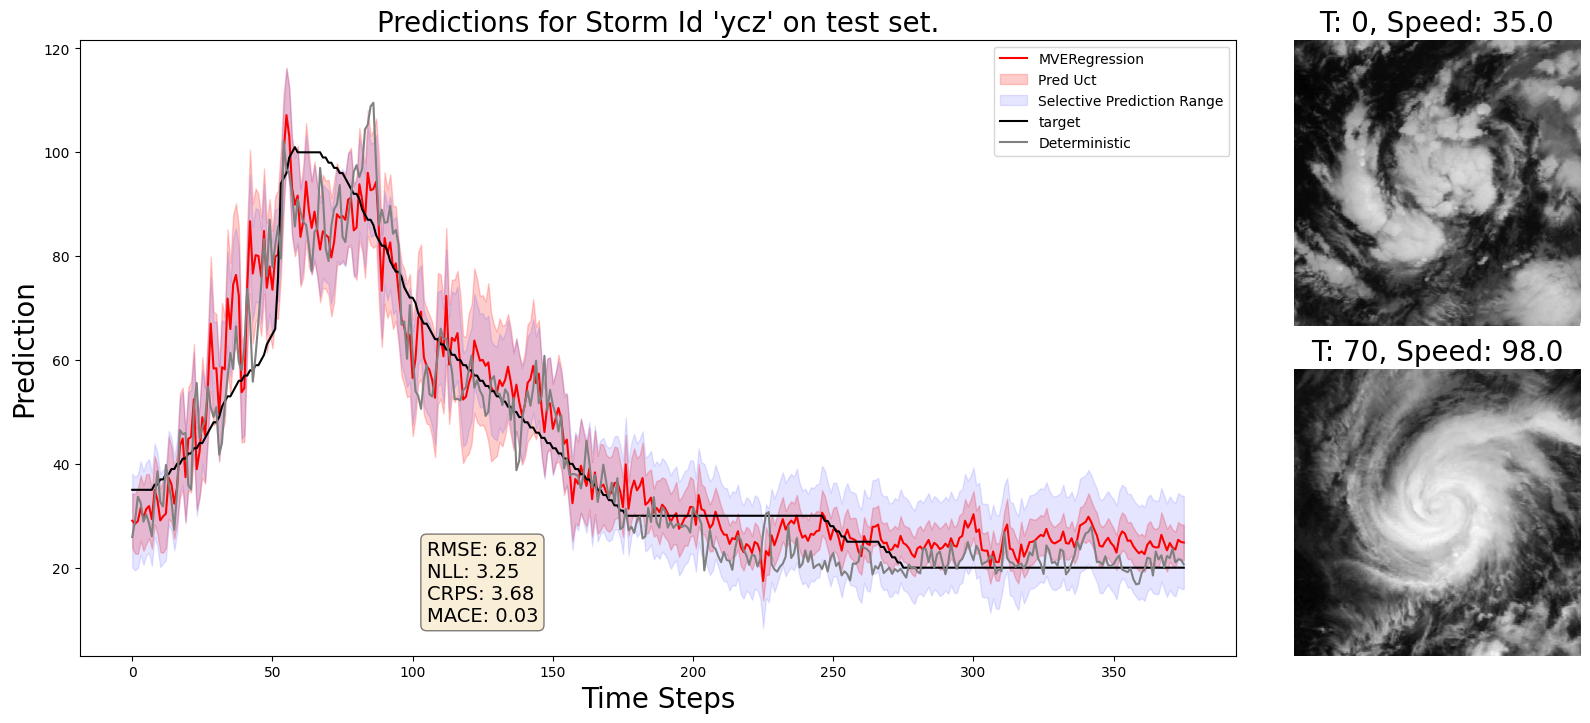

In [ ]:
def plot_track(
    all_test_pred_df,
    storm_id,
    split,
):
    """Generate a plot showing the predictions for a given storm_id over time."""
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]

    plot_df = plot_df[plot_df["storm_id"] == storm_id]
    plot_df = plot_df.sort_values(by="relative_time")

    # a mapping from relative_time to timestep
    unique_times = plot_df["relative_time"].unique()
    time_to_timestep = {time: i for i, time in enumerate(unique_times)}
    plot_df["timestep"] = plot_df["relative_time"].map(time_to_timestep)

    # iterate over the uqmethods
    unique_methods = plot_df["uqmethod"].unique()

    unique_methods = ["MVERegression"]

    ds = {"train": dataset, "val": dataset, "test": test_ds}[split]

    # Create a figure and a grid of subplots
    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(2, 2, figure=fig, hspace=0.15, wspace=0.01, width_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    # unique_methods = plot_df["uqmethod"].unique()

    for idx, method in enumerate(unique_methods):
        method_df = plot_df[plot_df["uqmethod"] == method]

        # Compute metrics for this storm track
        rmse = np.sqrt(np.mean((method_df["pred"] - method_df["target"]) ** 2))
        nll = uct_score.nll_gaussian(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )
        crps = uct_score.crps_gaussian(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )
        mace = uct_cal.mean_absolute_calibration_error(
            method_df["pred"].values,
            method_df["pred_uct"].values,
            method_df["target"].values,
        )

        metrics_text = (
            f"RMSE: {rmse:.2f}\nNLL: {nll:.2f}\nCRPS: {crps:.2f}\nMACE: {mace:.2f}"
        )

        ax1.plot(
            method_df["timestep"],
            method_df["pred"],
            label=method,
    
            c="red",
        )
        ax1.fill_between(
            method_df["timestep"],
            method_df["pred"] - method_df["pred_uct"],
            method_df["pred"] + method_df["pred_uct"],
            color="red",
            alpha=0.2,
            label="Pred Uct",
        )

        props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    
        ax1.text(
            0.3,
            0.05,
            metrics_text,
            transform=ax1.transAxes,
            fontsize=14,
            verticalalignment="bottom",
            bbox=props,
        )
        
        ax1.fill_between(
            method_df["timestep"],
            method_df["pred"] - SELECTIVE_THRESH,
            method_df["pred"] + SELECTIVE_THRESH,
            color="blue",
            alpha=0.1,
            label="Selective Prediction Range",
        )

    # plot ground truth just from last one since it is the same for all
    ax1.plot(method_df["timestep"], method_df["target"], label="target", c="black")

    # plot the deterministic model prediction
    ax1.plot(
        plot_df[plot_df["uqmethod"] == "DeterministicRegression"]["timestep"],
        plot_df[plot_df["uqmethod"] == "DeterministicRegression"]["pred"],
        label="Deterministic",
        c="gray",
    )

    ax1.legend()

    ax1.set_title(f"Predictions for Storm Id '{storm_id}' on {split} set.", fontsize=20)
    ax1.set_ylabel("Prediction", fontsize=20)
    ax1.set_xlabel("Time Steps", fontsize=20)

    # Display the image from the beginning timestep
    rel_time_index = 0
    first_image_index = int(method_df.iloc[rel_time_index]["index"])
    first_sample = ds[first_image_index]
    first_image = first_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax2.imshow(first_image, cmap="gray")
    ax2.set_title(
        f"T: {rel_time_index}, Speed: {first_sample['target'].item()}", fontsize=20
    )
    ax2.axis("off")

    # Display the image from the end timestep
    rel_time_index = 70
    last_image_index = int(method_df.iloc[rel_time_index]["index"])
    last_sample = ds[last_image_index]
    last_image = last_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax3.imshow(last_image, cmap="gray")
    ax3.set_title(
        f"T: {rel_time_index}, Speed: {last_sample['target'].item()}", fontsize=20
    )
    ax3.axis("off")

    plt.show()


random_storm_id = error_by_storm_id["storm_id"].sample(1).values[0]

# Plot the track for the random storm_id
plot_track(all_test_pred_df, "ycz", DS_SPLIT)

# test "ycz", "roe", "hep", "tbs", "ibx"

# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence
from tropical_cyclone_dm import MyDigitalTyphoonAnalysis

# path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"
path = "/p/project/hai_uqmethodbox/data/digital_typhoon"

# train_ds = TropicalCycloneSequence(root=path)
train_ds = MyDigitalTyphoonAnalysis(root=path, min_feature_value={"wind": 34})

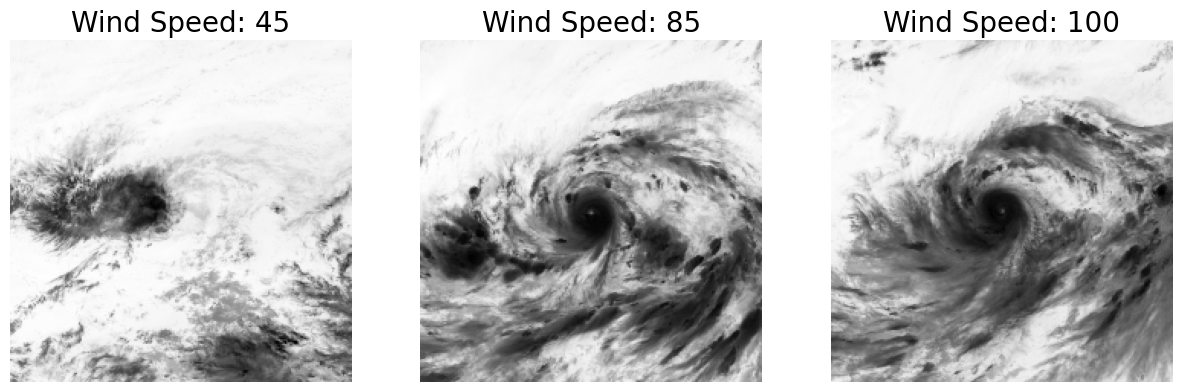

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ranges = [CLASS_BINS["TS"], CLASS_BINS["H2"], CLASS_BINS["H3"]]

# # Create a subplot to display the images
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, (min_speed, max_speed) in enumerate(ranges):
#     # Iterate through the dataset until you find a sample in the current wind speed range
#     for idx, sample in tqdm(enumerate(train_ds)):

#         if min_speed <= int(sample["target"]) < max_speed:
#             print(idx)
#             break

#     image = sample["input"].numpy().transpose(1, 2, 0) / 255

#     # Display the image and set the title to the target value
#     axes[i].imshow(image, cmap='gray')
#     axes[i].set_title(f'Wind Speed: {int(sample["target"])}')
#     axes[i].axis('off')

# plt.show()

# Define the indices of the samples you need
indices = [0, 2646, 2555]  # tropical cyclone
indices = [0, 171, 189]  # digital typhoon

# Create a subplot to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, index in enumerate(indices):
    # Retrieve the sample from the dataset
    sample = train_ds[index]

    image = sample["input"].numpy().transpose(1, 2, 0)[..., 0]

    # Display the image and set the title to the target value
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f'Wind Speed: {int(sample["target"])}', fontsize=20)
    axes[i].axis("off")

plt.show()

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data


def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df

    # Specify the number of processes to use for parallel execution
    num_processes = 8 
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 0, 'Wind Speed in knots')

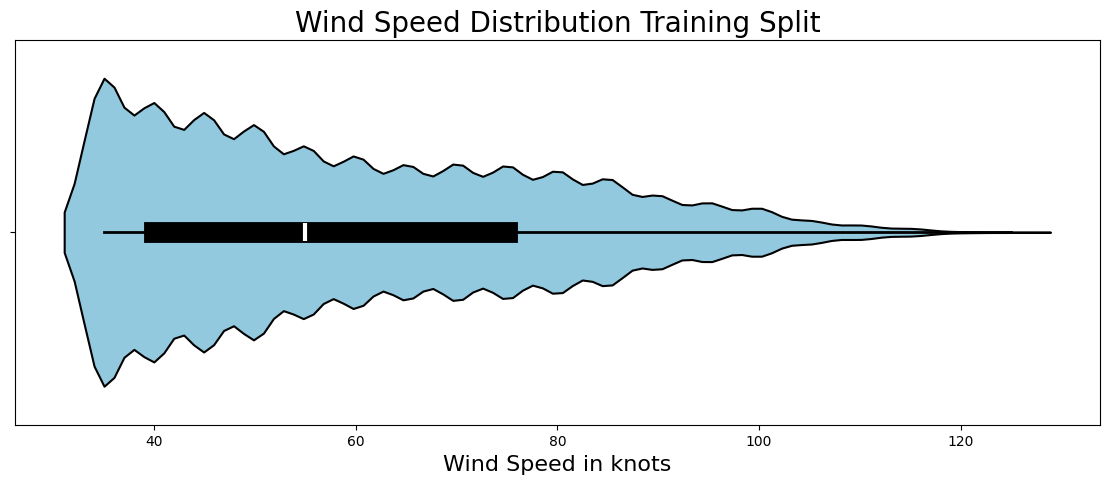

In [ ]:
sns.violinplot(
    x=train_df["wind"],
    orient="h",
    color="skyblue",
    inner_kws=dict(box_width=15, whis_width=2, color="black"),
    linewidth=1.5,
    linecolor="k",
)
plt.title(f"Wind Speed Distribution Training Split", fontsize=20)
plt.xlabel("Wind Speed in knots", fontsize=16)

Text(0.5, 1.0, 'Histogram of wind speeds')

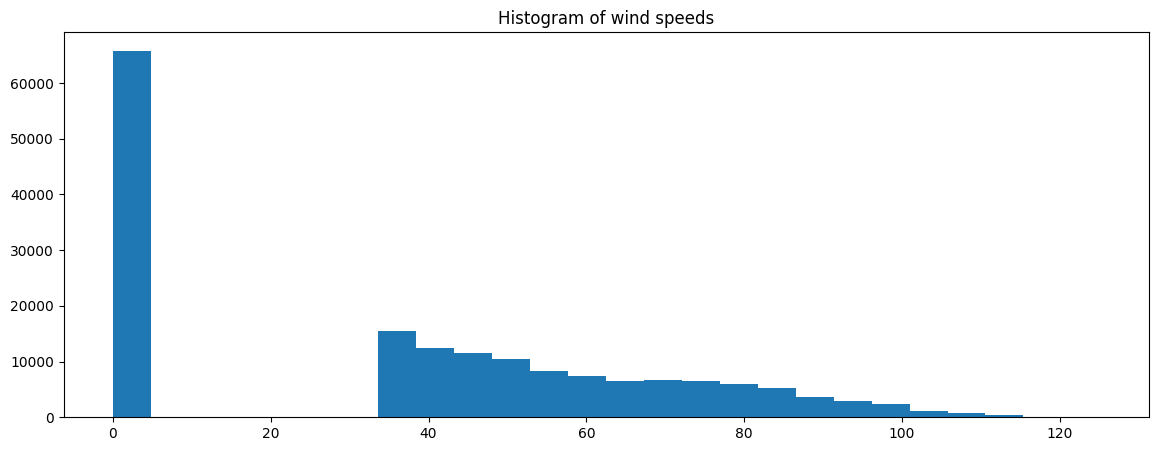

In [ ]:
plt.hist(train_df["wind"], bins=26)
plt.title("Histogram of wind speeds")

/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


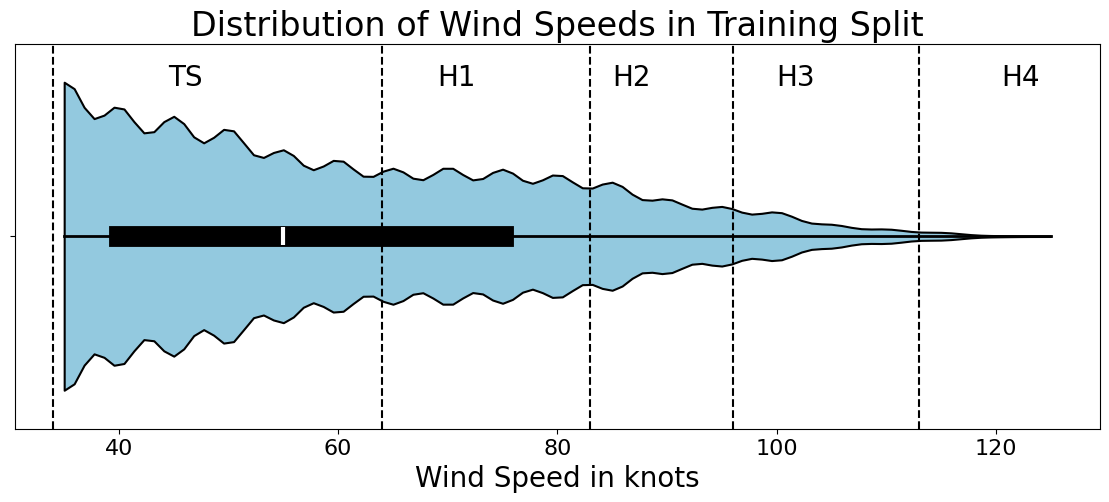

In [ ]:
import seaborn as sns


CLASS_BINS = {
    # "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    # "H5": (137, np.inf),
}

sns.violinplot(
    x=train_df["wind"],
    orient="h",
    color="skyblue",
    inner_kws=dict(box_width=15, whis_width=2, color="black"),
    linewidth=1.5,
    linecolor="k",
    cut=0,
)

for category, (min_speed, max_speed) in CLASS_BINS.items():
    midpoint = (min_speed + max_speed) / 2 - 4
    plt.axvline(x=min_speed, color="black", linestyle="--")
    plt.text(
        midpoint,
        plt.gca().get_ylim()[1] * 0.9,
        category,
        color="black",
        fontsize=20,
        verticalalignment="top",
    )

plt.xlabel("Wind Speed in knots", fontsize=20)
plt.title("Distribution of Wind Speeds in Training Split", fontsize=24)

plt.xticks(fontsize=16)

plt.show()